In [1]:
!git clone http://github.com/Zapy67/ATML-PA-4 test

fatal: destination path 'test' already exists and is not an empty directory.


In [5]:
!git pull http://github.com/Zapy67/ATML-PA-4 test

From http://github.com/Zapy67/ATML-PA-4
 * branch            test       -> FETCH_HEAD
Updating 8bc2290..3131aec
Fast-forward
 fed_lib/fed_methods.py |  1133 +---
 fed_lib/fed_model.py   |     4 +-
 fed_lib/utils.py       |    27 +-
 fedgh.ipynb            |   422 ++
 fedprox.ipynb          |   548 ++
 fedsam.ipynb           | 15675 +++--------------------------------------------
 task1.ipynb            |     6 +-
 task2.ipynb            |  3529 +++++++----
 8 files changed, 4293 insertions(+), 17051 deletions(-)


In [3]:
%cd test

/kaggle/working/test


In [4]:
!ls

'ATML - PA 4.pdf'   fedprox.ipynb       README.md     task4.ipynb
 data		    fedsam.ipynb        task1.ipynb
 fedgh.ipynb	    fedscaffold.ipynb   task2.ipynb
 fed_lib	    LICENSE	        task3.ipynb


#  FedProx

In [6]:
import torch
import torch.nn as nn

In [7]:
# !pip install fedlab

In [8]:
import fed_lib
import importlib
importlib.reload(fed_lib)

<module 'fed_lib' from '/kaggle/working/test/fed_lib/__init__.py'>

In [9]:
from fed_lib import fed_methods, fed_model, utils
importlib.reload(fed_methods)
importlib.reload(fed_model)
importlib.reload(utils)

17:30:32 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


<module 'fed_lib.utils' from '/kaggle/working/test/fed_lib/utils.py'>

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
import matplotlib.pyplot as plt
def plot_fed_vs_central_acc(metrics, title="FedProx vs Central Test Accuracy"):
    """
    Args:
        metrics (dict): self.round_metrics dictionary from FedSGD.
    """
    fed_acc = metrics.get('fed_test_acc', [])
    central_acc = metrics.get('central_test_acc', [])

    rounds = list(range(1, len(fed_acc) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, fed_acc, marker='o', label='FedProx (Server) Accuracy')
    plt.plot(rounds, central_acc, marker='s', label='Central Model Accuracy')

    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [12]:
def plot_fed_test_acc(metrics, title="Federated Test Accuracy"):
    fed_acc = metrics.get('fed_test_acc', [])
    rounds = list(range(1, len(fed_acc) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, fed_acc, marker='o', label='Fed Test Accuracy')

    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [13]:
def plot_client_drift(metrics, title="Client Drift Over Rounds"):
    drift = metrics.get('client_drift', [])
    rounds = list(range(1, len(drift) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, drift, marker='s', label='Client Drift')

    plt.xlabel("Round")
    plt.ylabel("Drift")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [14]:
def fed_prox_exp(lr=1e-3, num_steps=5, num_clients=5, partition="dirichlet", alpha=10000,device=device, global_runs=20, verbose=False, sampling_frac=1.0, mu=0.01, train_central=False):
        
        fed = fed_model.Federation(num_clients=num_clients, federate_method=None, partition=partition, domains=None, alpha=alpha, device=device, batch_size=64, pin_memory=True, num_workers=2)
        client_loaders = fed.client_dataloaders
        client_weights = [len(client.dataset.indices)/len(fed.centralized_train_loader) for client in client_loaders]

        fed_meth = fed_methods.FedProx(local_epochs=1, aggregation_steps=num_steps, client_weights=client_weights, sample_fraction=sampling_frac, mu=mu)

        fed.set_method(fed_meth)
        fed.train(global_runs, lr=lr, verbose=verbose, train_central=train_central)

        return fed

In [43]:
# f = fed_prox_exp(num_steps=5, global_runs=5, mu=0.01, train_central=True)
# plot_fed_test_acc(f.federated_method.round_metrics, f"FedProx (k={5} local rounds) Test Accuracy")
# plot_client_drift(f.federated_method.round_metrics, f"Client Drift (k={5} local rounds)")

In [40]:
def plot_metrics(metrics:dict, title:str, label: str, label_desc:str):
    metric_map = {
        'fed_test_acc': 'Test Accuracy',
        'fed_test_loss': 'Test Loss',
        'client_drift': 'Client Drift (Norm)'
    }
    metric_order = ['fed_test_acc', 'fed_test_loss', 'client_drift']
    k_values = sorted(metrics.keys())

    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    fig.suptitle(title, fontsize=14)


    for i, metric_key in enumerate(metric_order):
        ax = axes[i]
        for k in k_values:
            values = metrics[k][metric_key]
            rounds = list(range(1, len(values) + 1))
            ax.plot(rounds, values, label=f'{label}={k}')
            
        ax.set_ylabel(metric_map[metric_key])
        ax.grid(axis='y', linestyle='--', alpha=0.6)    
        ax.legend(title=f'{label_desc} ({label})', loc='upper left')
            
    axes[-1].set_xlabel('Global Round')
    plt.show()

In [16]:
trainset, testset = utils.get_cifar10()

In [17]:
from IPython.display import clear_output
metrics_exp_1 = {}
total_samples = len(trainset.dataset)

In [18]:
print(f"Testing for mu={1e-4}\n")
f = fed_prox_exp(lr=1e-2, num_clients=5,num_steps=75, global_runs=30, sampling_frac=1.0, mu=1e-4, alpha=10)
metrics_exp_1[1e-4] = f.federated_method.round_metrics
clear_output(wait=True)

Testing for mu=0.0001


--- Round 1/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 7.383937e-01
Client Drift Std: 2.875845e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :7.040350e-01
Client Number: 4 Drift :7.135343e-01
Client Number: 1 Drift :7.302316e-01
Client Number: 2 Drift :7.718930e-01
Client Number: 3 Drift :7.722746e-01

Evaluate on round 1:


FedProx  | Test Loss: 1.7902, Test Acc: 32.35%

--- Round 2/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.151919e-01
Client Drift Std: 2.689843e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :4.846854e-01
Client Number: 0 Drift :4.868512e-01
Client Number: 1 Drift :5.145798e-01
Client Number: 3 Drift :5.373155e-01
Client Number: 2 Drift :5.525276e-01

Evaluate on round 2:


FedProx  | Test Loss: 1.6054, Test Acc: 40.56%

--- Round 3/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.527998e-01
Client Drift Std: 3.148419e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :4.197928e-01
Client Number: 4 Drift :4.219597e-01
Client Number: 1 Drift :4.440871e-01
Client Number: 2 Drift :4.788990e-01
Client Number: 3 Drift :4.992607e-01

Evaluate on round 3:


FedProx  | Test Loss: 1.5075, Test Acc: 44.82%

--- Round 4/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.214284e-01
Client Drift Std: 3.507324e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.859915e-01
Client Number: 0 Drift :3.890440e-01
Client Number: 1 Drift :4.104902e-01
Client Number: 2 Drift :4.431311e-01
Client Number: 3 Drift :4.784853e-01

Evaluate on round 4:


FedProx  | Test Loss: 1.4454, Test Acc: 47.33%

--- Round 5/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.008766e-01
Client Drift Std: 2.631226e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.724414e-01
Client Number: 4 Drift :3.763109e-01
Client Number: 1 Drift :3.920417e-01
Client Number: 2 Drift :4.263296e-01
Client Number: 3 Drift :4.372596e-01

Evaluate on round 5:


FedProx  | Test Loss: 1.4052, Test Acc: 49.04%

--- Round 6/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.853855e-01
Client Drift Std: 2.135110e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.622633e-01
Client Number: 0 Drift :3.671309e-01
Client Number: 1 Drift :3.755184e-01
Client Number: 3 Drift :4.102525e-01
Client Number: 2 Drift :4.117626e-01

Evaluate on round 6:


FedProx  | Test Loss: 1.3623, Test Acc: 50.96%

--- Round 7/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.837950e-01
Client Drift Std: 3.103888e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.566585e-01
Client Number: 4 Drift :3.579728e-01
Client Number: 1 Drift :3.666817e-01
Client Number: 2 Drift :4.005831e-01
Client Number: 3 Drift :4.370789e-01

Evaluate on round 7:


FedProx  | Test Loss: 1.2765, Test Acc: 53.86%

--- Round 8/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.801323e-01
Client Drift Std: 3.738083e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.465603e-01
Client Number: 0 Drift :3.499087e-01
Client Number: 1 Drift :3.640628e-01
Client Number: 2 Drift :3.926910e-01
Client Number: 3 Drift :4.474386e-01

Evaluate on round 8:


FedProx  | Test Loss: 1.3408, Test Acc: 51.41%

--- Round 9/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.706893e-01
Client Drift Std: 2.267694e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.483599e-01
Client Number: 4 Drift :3.497696e-01
Client Number: 1 Drift :3.592126e-01
Client Number: 2 Drift :3.963450e-01
Client Number: 3 Drift :3.997592e-01

Evaluate on round 9:


FedProx  | Test Loss: 1.2614, Test Acc: 55.03%

--- Round 10/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.588334e-01
Client Drift Std: 1.531656e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.411156e-01
Client Number: 0 Drift :3.482046e-01
Client Number: 1 Drift :3.546780e-01
Client Number: 3 Drift :3.650683e-01
Client Number: 2 Drift :3.851003e-01

Evaluate on round 10:


FedProx  | Test Loss: 1.2750, Test Acc: 54.67%

--- Round 11/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.666423e-01
Client Drift Std: 3.717318e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.333521e-01
Client Number: 0 Drift :3.387703e-01
Client Number: 1 Drift :3.451493e-01
Client Number: 2 Drift :3.840303e-01
Client Number: 3 Drift :4.319098e-01

Evaluate on round 11:


FedProx  | Test Loss: 1.2455, Test Acc: 56.08%

--- Round 12/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.578810e-01
Client Drift Std: 2.341640e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.327736e-01
Client Number: 0 Drift :3.372239e-01
Client Number: 1 Drift :3.483519e-01
Client Number: 2 Drift :3.798245e-01
Client Number: 3 Drift :3.912310e-01

Evaluate on round 12:


FedProx  | Test Loss: 1.2403, Test Acc: 55.87%

--- Round 13/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.536699e-01
Client Drift Std: 1.824916e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.316630e-01
Client Number: 0 Drift :3.430358e-01
Client Number: 1 Drift :3.430755e-01
Client Number: 3 Drift :3.720569e-01
Client Number: 2 Drift :3.785184e-01

Evaluate on round 13:


FedProx  | Test Loss: 1.2062, Test Acc: 56.88%

--- Round 14/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.583812e-01
Client Drift Std: 3.188872e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.288748e-01
Client Number: 0 Drift :3.339761e-01
Client Number: 1 Drift :3.403443e-01
Client Number: 2 Drift :3.755856e-01
Client Number: 3 Drift :4.131251e-01

Evaluate on round 14:


FedProx  | Test Loss: 1.1494, Test Acc: 58.95%

--- Round 15/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.567233e-01
Client Drift Std: 2.739113e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.295465e-01
Client Number: 1 Drift :3.379063e-01
Client Number: 0 Drift :3.402386e-01
Client Number: 2 Drift :3.732118e-01
Client Number: 3 Drift :4.027134e-01

Evaluate on round 15:


FedProx  | Test Loss: 1.0464, Test Acc: 62.32%

--- Round 16/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.530749e-01
Client Drift Std: 2.937226e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.235833e-01
Client Number: 0 Drift :3.317530e-01
Client Number: 1 Drift :3.377014e-01
Client Number: 2 Drift :3.693971e-01
Client Number: 3 Drift :4.029398e-01

Evaluate on round 16:


FedProx  | Test Loss: 1.0678, Test Acc: 61.76%

--- Round 17/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.470783e-01
Client Drift Std: 2.513113e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.183126e-01
Client Number: 0 Drift :3.264323e-01
Client Number: 1 Drift :3.379157e-01
Client Number: 2 Drift :3.691291e-01
Client Number: 3 Drift :3.836017e-01

Evaluate on round 17:


FedProx  | Test Loss: 1.0527, Test Acc: 62.56%

--- Round 18/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.398279e-01
Client Drift Std: 1.841411e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.221979e-01
Client Number: 0 Drift :3.235233e-01
Client Number: 1 Drift :3.320410e-01
Client Number: 3 Drift :3.509992e-01
Client Number: 2 Drift :3.703780e-01

Evaluate on round 18:


FedProx  | Test Loss: 1.0533, Test Acc: 62.64%

--- Round 19/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.374597e-01
Client Drift Std: 1.964154e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.178539e-01
Client Number: 0 Drift :3.194028e-01
Client Number: 1 Drift :3.289896e-01
Client Number: 3 Drift :3.540977e-01
Client Number: 2 Drift :3.669546e-01

Evaluate on round 19:


FedProx  | Test Loss: 1.0312, Test Acc: 63.43%

--- Round 20/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.402270e-01
Client Drift Std: 2.132039e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.166655e-01
Client Number: 0 Drift :3.217829e-01
Client Number: 1 Drift :3.313075e-01
Client Number: 2 Drift :3.649092e-01
Client Number: 3 Drift :3.664700e-01

Evaluate on round 20:


FedProx  | Test Loss: 0.9753, Test Acc: 65.21%

--- Round 21/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.410717e-01
Client Drift Std: 2.577877e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.147758e-01
Client Number: 0 Drift :3.184505e-01
Client Number: 1 Drift :3.295138e-01
Client Number: 2 Drift :3.624404e-01
Client Number: 3 Drift :3.801782e-01

Evaluate on round 21:


FedProx  | Test Loss: 1.1557, Test Acc: 60.01%

--- Round 22/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.285570e-01
Client Drift Std: 1.652080e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.122783e-01
Client Number: 0 Drift :3.210388e-01
Client Number: 3 Drift :3.225619e-01
Client Number: 1 Drift :3.266683e-01
Client Number: 2 Drift :3.602375e-01

Evaluate on round 22:


FedProx  | Test Loss: 1.0174, Test Acc: 63.88%

--- Round 23/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.313388e-01
Client Drift Std: 1.769808e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.145288e-01
Client Number: 0 Drift :3.173327e-01
Client Number: 1 Drift :3.223966e-01
Client Number: 3 Drift :3.408009e-01
Client Number: 2 Drift :3.616351e-01

Evaluate on round 23:


FedProx  | Test Loss: 0.9640, Test Acc: 65.66%

--- Round 24/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.406330e-01
Client Drift Std: 3.189977e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.095675e-01
Client Number: 0 Drift :3.169535e-01
Client Number: 1 Drift :3.242393e-01
Client Number: 2 Drift :3.566692e-01
Client Number: 3 Drift :3.957354e-01

Evaluate on round 24:


FedProx  | Test Loss: 0.9580, Test Acc: 66.00%

--- Round 25/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.632683e-01
Client Drift Std: 7.878025e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.112167e-01
Client Number: 0 Drift :3.145830e-01
Client Number: 1 Drift :3.195587e-01
Client Number: 2 Drift :3.530019e-01
Client Number: 3 Drift :5.179812e-01

Evaluate on round 25:


FedProx  | Test Loss: 1.0753, Test Acc: 62.25%

--- Round 26/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.340355e-01
Client Drift Std: 1.911645e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.140702e-01
Client Number: 0 Drift :3.200444e-01
Client Number: 1 Drift :3.233696e-01
Client Number: 3 Drift :3.484886e-01
Client Number: 2 Drift :3.642046e-01

Evaluate on round 26:


FedProx  | Test Loss: 0.8966, Test Acc: 67.98%

--- Round 27/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.322912e-01
Client Drift Std: 2.573205e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.084929e-01
Client Number: 4 Drift :3.087132e-01
Client Number: 1 Drift :3.196440e-01
Client Number: 2 Drift :3.516487e-01
Client Number: 3 Drift :3.729574e-01

Evaluate on round 27:


FedProx  | Test Loss: 0.9541, Test Acc: 66.54%

--- Round 28/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.607411e-01
Client Drift Std: 7.551084e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.088742e-01
Client Number: 0 Drift :3.141070e-01
Client Number: 1 Drift :3.171594e-01
Client Number: 2 Drift :3.554564e-01
Client Number: 3 Drift :5.081087e-01

Evaluate on round 28:


FedProx  | Test Loss: 0.9554, Test Acc: 65.85%

--- Round 29/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.398632e-01
Client Drift Std: 3.399415e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.082184e-01
Client Number: 0 Drift :3.153306e-01
Client Number: 1 Drift :3.191057e-01
Client Number: 2 Drift :3.585262e-01
Client Number: 3 Drift :3.981349e-01

Evaluate on round 29:


FedProx  | Test Loss: 0.8938, Test Acc: 68.26%

--- Round 30/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.270275e-01
Client Drift Std: 1.762664e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.092410e-01
Client Number: 4 Drift :3.101489e-01
Client Number: 1 Drift :3.198699e-01
Client Number: 3 Drift :3.443031e-01
Client Number: 2 Drift :3.515748e-01

Evaluate on round 30:


FedProx  | Test Loss: 0.9007, Test Acc: 68.16%
Training Complete!


FedProx  | Test Loss: 0.9007, Test Acc: 68.16%


In [20]:
import json
with open('metrics_exp_1.json', 'w') as f:
    json.dump(metrics_exp_1, f, indent=4)

In [21]:
print(f"Testing for mu={0.01}\n")
f = fed_prox_exp(lr=1e-2, num_clients=5,num_steps=75, global_runs=30, sampling_frac=1.0, mu=0.01, alpha=10)
metrics_exp_1[0.01] = f.federated_method.round_metrics
clear_output(wait=True)

Testing for mu=0.01


--- Round 1/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 7.470220e-01
Client Drift Std: 2.517653e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :7.191383e-01
Client Number: 0 Drift :7.284273e-01
Client Number: 1 Drift :7.335528e-01
Client Number: 2 Drift :7.711751e-01
Client Number: 3 Drift :7.828163e-01

Evaluate on round 1:


FedProx  | Test Loss: 1.7903, Test Acc: 33.34%

--- Round 2/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.296621e-01
Client Drift Std: 2.609009e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :5.032194e-01
Client Number: 1 Drift :5.062925e-01
Client Number: 0 Drift :5.167424e-01
Client Number: 2 Drift :5.575971e-01
Client Number: 3 Drift :5.644590e-01

Evaluate on round 2:


FedProx  | Test Loss: 1.5818, Test Acc: 41.88%

--- Round 3/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.589960e-01
Client Drift Std: 2.112035e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :4.382581e-01
Client Number: 1 Drift :4.434738e-01
Client Number: 0 Drift :4.457027e-01
Client Number: 3 Drift :4.749732e-01
Client Number: 2 Drift :4.925722e-01

Evaluate on round 3:


FedProx  | Test Loss: 1.5028, Test Acc: 44.21%

--- Round 4/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.291195e-01
Client Drift Std: 2.210901e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :4.074065e-01
Client Number: 0 Drift :4.121440e-01
Client Number: 1 Drift :4.140859e-01
Client Number: 3 Drift :4.532088e-01
Client Number: 2 Drift :4.587525e-01

Evaluate on round 4:


FedProx  | Test Loss: 1.4398, Test Acc: 47.38%

--- Round 5/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.123362e-01
Client Drift Std: 2.144995e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.922172e-01
Client Number: 0 Drift :3.924203e-01
Client Number: 1 Drift :4.004165e-01
Client Number: 3 Drift :4.363942e-01
Client Number: 2 Drift :4.402328e-01

Evaluate on round 5:


FedProx  | Test Loss: 1.3870, Test Acc: 49.37%

--- Round 6/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.004508e-01
Client Drift Std: 1.992456e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.815097e-01
Client Number: 0 Drift :3.848180e-01
Client Number: 1 Drift :3.864830e-01
Client Number: 3 Drift :4.226540e-01
Client Number: 2 Drift :4.267891e-01

Evaluate on round 6:


FedProx  | Test Loss: 1.3986, Test Acc: 50.01%

--- Round 7/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.955799e-01
Client Drift Std: 2.062061e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.694755e-01
Client Number: 0 Drift :3.822355e-01
Client Number: 1 Drift :3.875037e-01
Client Number: 3 Drift :4.133430e-01
Client Number: 2 Drift :4.253420e-01

Evaluate on round 7:


FedProx  | Test Loss: 1.4030, Test Acc: 49.37%

--- Round 8/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.913326e-01
Client Drift Std: 2.315038e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.677438e-01
Client Number: 4 Drift :3.704230e-01
Client Number: 1 Drift :3.806381e-01
Client Number: 3 Drift :4.140010e-01
Client Number: 2 Drift :4.238569e-01

Evaluate on round 8:


FedProx  | Test Loss: 1.3719, Test Acc: 51.33%

--- Round 9/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.863118e-01
Client Drift Std: 2.212060e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.587323e-01
Client Number: 0 Drift :3.682308e-01
Client Number: 1 Drift :3.811944e-01
Client Number: 3 Drift :4.070282e-01
Client Number: 2 Drift :4.163734e-01

Evaluate on round 9:


FedProx  | Test Loss: 1.2443, Test Acc: 55.45%

--- Round 10/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.811938e-01
Client Drift Std: 2.196347e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.544903e-01
Client Number: 1 Drift :3.691817e-01
Client Number: 0 Drift :3.692306e-01
Client Number: 3 Drift :3.985549e-01
Client Number: 2 Drift :4.145116e-01

Evaluate on round 10:


FedProx  | Test Loss: 1.2014, Test Acc: 56.91%

--- Round 11/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.760631e-01
Client Drift Std: 2.281080e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.507219e-01
Client Number: 0 Drift :3.555079e-01
Client Number: 1 Drift :3.682978e-01
Client Number: 3 Drift :3.985995e-01
Client Number: 2 Drift :4.071884e-01

Evaluate on round 11:


FedProx  | Test Loss: 1.1516, Test Acc: 58.92%

--- Round 12/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.734708e-01
Client Drift Std: 2.134927e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.452197e-01
Client Number: 1 Drift :3.630285e-01
Client Number: 0 Drift :3.636643e-01
Client Number: 3 Drift :3.906667e-01
Client Number: 2 Drift :4.047745e-01

Evaluate on round 12:


FedProx  | Test Loss: 1.1489, Test Acc: 59.19%

--- Round 13/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.706625e-01
Client Drift Std: 1.981333e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.451082e-01
Client Number: 0 Drift :3.570143e-01
Client Number: 1 Drift :3.660177e-01
Client Number: 3 Drift :3.841992e-01
Client Number: 2 Drift :4.009731e-01

Evaluate on round 13:


FedProx  | Test Loss: 1.1536, Test Acc: 59.45%

--- Round 14/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.642228e-01
Client Drift Std: 2.023109e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.383890e-01
Client Number: 0 Drift :3.514921e-01
Client Number: 1 Drift :3.559800e-01
Client Number: 3 Drift :3.824477e-01
Client Number: 2 Drift :3.928050e-01

Evaluate on round 14:


FedProx  | Test Loss: 1.1677, Test Acc: 59.25%

--- Round 15/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.661628e-01
Client Drift Std: 2.249182e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.407223e-01
Client Number: 1 Drift :3.518164e-01
Client Number: 0 Drift :3.545993e-01
Client Number: 3 Drift :3.812492e-01
Client Number: 2 Drift :4.024265e-01

Evaluate on round 15:


FedProx  | Test Loss: 1.0323, Test Acc: 63.11%

--- Round 16/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.576702e-01
Client Drift Std: 2.257268e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.336406e-01
Client Number: 0 Drift :3.383152e-01
Client Number: 1 Drift :3.490708e-01
Client Number: 3 Drift :3.744296e-01
Client Number: 2 Drift :3.928947e-01

Evaluate on round 16:


FedProx  | Test Loss: 1.1123, Test Acc: 60.86%

--- Round 17/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.544674e-01
Client Drift Std: 2.306421e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.250932e-01
Client Number: 0 Drift :3.381069e-01
Client Number: 1 Drift :3.480012e-01
Client Number: 3 Drift :3.726616e-01
Client Number: 2 Drift :3.884738e-01

Evaluate on round 17:


FedProx  | Test Loss: 1.0202, Test Acc: 63.80%

--- Round 18/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.524734e-01
Client Drift Std: 1.948406e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.284807e-01
Client Number: 0 Drift :3.367461e-01
Client Number: 1 Drift :3.471921e-01
Client Number: 3 Drift :3.708084e-01
Client Number: 2 Drift :3.791396e-01

Evaluate on round 18:


FedProx  | Test Loss: 1.0377, Test Acc: 63.41%

--- Round 19/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.493392e-01
Client Drift Std: 2.092132e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.197741e-01
Client Number: 1 Drift :3.388805e-01
Client Number: 0 Drift :3.422766e-01
Client Number: 3 Drift :3.680570e-01
Client Number: 2 Drift :3.777081e-01

Evaluate on round 19:


FedProx  | Test Loss: 1.0680, Test Acc: 62.87%

--- Round 20/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.551057e-01
Client Drift Std: 2.073161e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.274816e-01
Client Number: 1 Drift :3.434650e-01
Client Number: 0 Drift :3.479518e-01
Client Number: 3 Drift :3.705092e-01
Client Number: 2 Drift :3.861211e-01

Evaluate on round 20:


FedProx  | Test Loss: 0.9931, Test Acc: 65.24%

--- Round 21/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.509358e-01
Client Drift Std: 2.430566e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.185843e-01
Client Number: 0 Drift :3.347235e-01
Client Number: 1 Drift :3.448077e-01
Client Number: 3 Drift :3.708251e-01
Client Number: 2 Drift :3.857385e-01

Evaluate on round 21:


FedProx  | Test Loss: 0.9798, Test Acc: 65.40%

--- Round 22/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.464766e-01
Client Drift Std: 1.650143e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.239983e-01
Client Number: 0 Drift :3.372360e-01
Client Number: 1 Drift :3.407646e-01
Client Number: 3 Drift :3.608516e-01
Client Number: 2 Drift :3.695321e-01

Evaluate on round 22:


FedProx  | Test Loss: 0.9387, Test Acc: 66.51%

--- Round 23/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.462786e-01
Client Drift Std: 1.944176e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.149550e-01
Client Number: 0 Drift :3.396552e-01
Client Number: 1 Drift :3.433600e-01
Client Number: 3 Drift :3.634441e-01
Client Number: 2 Drift :3.699788e-01

Evaluate on round 23:


FedProx  | Test Loss: 0.8998, Test Acc: 68.15%

--- Round 24/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.426993e-01
Client Drift Std: 2.063915e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.163139e-01
Client Number: 0 Drift :3.286191e-01
Client Number: 1 Drift :3.355931e-01
Client Number: 3 Drift :3.613193e-01
Client Number: 2 Drift :3.716514e-01

Evaluate on round 24:


FedProx  | Test Loss: 0.9285, Test Acc: 67.19%

--- Round 25/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.393535e-01
Client Drift Std: 1.994514e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.133977e-01
Client Number: 0 Drift :3.229533e-01
Client Number: 1 Drift :3.370966e-01
Client Number: 3 Drift :3.568576e-01
Client Number: 2 Drift :3.664623e-01

Evaluate on round 25:


FedProx  | Test Loss: 0.8947, Test Acc: 68.49%

--- Round 26/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.384874e-01
Client Drift Std: 2.042550e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.135189e-01
Client Number: 0 Drift :3.236862e-01
Client Number: 1 Drift :3.313714e-01
Client Number: 3 Drift :3.550841e-01
Client Number: 2 Drift :3.687762e-01

Evaluate on round 26:


FedProx  | Test Loss: 0.8518, Test Acc: 69.86%

--- Round 27/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.395514e-01
Client Drift Std: 2.195667e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.103740e-01
Client Number: 0 Drift :3.230661e-01
Client Number: 1 Drift :3.353147e-01
Client Number: 3 Drift :3.610032e-01
Client Number: 2 Drift :3.679989e-01

Evaluate on round 27:


FedProx  | Test Loss: 0.8765, Test Acc: 69.24%

--- Round 28/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.364409e-01
Client Drift Std: 1.912895e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.097758e-01
Client Number: 0 Drift :3.263569e-01
Client Number: 1 Drift :3.293333e-01
Client Number: 3 Drift :3.568439e-01
Client Number: 2 Drift :3.598944e-01

Evaluate on round 28:


FedProx  | Test Loss: 0.8462, Test Acc: 70.17%

--- Round 29/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.380931e-01
Client Drift Std: 1.905820e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.097920e-01
Client Number: 0 Drift :3.294949e-01
Client Number: 1 Drift :3.328467e-01
Client Number: 3 Drift :3.555920e-01
Client Number: 2 Drift :3.627397e-01

Evaluate on round 29:


FedProx  | Test Loss: 0.8589, Test Acc: 69.58%

--- Round 30/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.372398e-01
Client Drift Std: 2.361024e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.103296e-01
Client Number: 0 Drift :3.136688e-01
Client Number: 1 Drift :3.338091e-01
Client Number: 3 Drift :3.595891e-01
Client Number: 2 Drift :3.688025e-01

Evaluate on round 30:


FedProx  | Test Loss: 0.8183, Test Acc: 71.23%
Training Complete!


FedProx  | Test Loss: 0.8183, Test Acc: 71.23%


In [22]:
import json
with open('metrics_exp_1.json', 'w') as f:
    json.dump(metrics_exp_1, f, indent=4)

In [23]:
print(f"Testing for mu={1}\n")
f = fed_prox_exp(lr=1e-2, num_clients=5,num_steps=75, global_runs=30, sampling_frac=1.0, mu=1, alpha=10)
metrics_exp_1[1] = f.federated_method.round_metrics
clear_output(wait=True)

Testing for mu=1


--- Round 1/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.848604e-01
Client Drift Std: 2.347259e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :5.613950e-01
Client Number: 0 Drift :5.638021e-01
Client Number: 3 Drift :5.738950e-01
Client Number: 1 Drift :6.054989e-01
Client Number: 4 Drift :6.197108e-01

Evaluate on round 1:


FedProx  | Test Loss: 1.8297, Test Acc: 30.88%

--- Round 2/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.308646e-01
Client Drift Std: 2.481885e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :4.059496e-01
Client Number: 2 Drift :4.069847e-01
Client Number: 3 Drift :4.219717e-01
Client Number: 1 Drift :4.511687e-01
Client Number: 4 Drift :4.682481e-01

Evaluate on round 2:


FedProx  | Test Loss: 1.6805, Test Acc: 38.65%

--- Round 3/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.692987e-01
Client Drift Std: 2.641938e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.454174e-01
Client Number: 0 Drift :3.458065e-01
Client Number: 3 Drift :3.564635e-01
Client Number: 1 Drift :3.854307e-01
Client Number: 4 Drift :4.133752e-01

Evaluate on round 3:


FedProx  | Test Loss: 1.5898, Test Acc: 41.90%

--- Round 4/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.429163e-01
Client Drift Std: 2.390291e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.179668e-01
Client Number: 3 Drift :3.265842e-01
Client Number: 0 Drift :3.297203e-01
Client Number: 1 Drift :3.577155e-01
Client Number: 4 Drift :3.825948e-01

Evaluate on round 4:


FedProx  | Test Loss: 1.5034, Test Acc: 45.64%

--- Round 5/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.300762e-01
Client Drift Std: 2.365318e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.077950e-01
Client Number: 2 Drift :3.101198e-01
Client Number: 3 Drift :3.180336e-01
Client Number: 1 Drift :3.452901e-01
Client Number: 4 Drift :3.691424e-01

Evaluate on round 5:


FedProx  | Test Loss: 1.4532, Test Acc: 46.49%

--- Round 6/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.213034e-01
Client Drift Std: 2.698352e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :2.957334e-01
Client Number: 0 Drift :2.964679e-01
Client Number: 3 Drift :3.106976e-01
Client Number: 1 Drift :3.377329e-01
Client Number: 4 Drift :3.658850e-01

Evaluate on round 6:


FedProx  | Test Loss: 1.4203, Test Acc: 48.48%

--- Round 7/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.174742e-01
Client Drift Std: 2.458869e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.941539e-01
Client Number: 2 Drift :3.002389e-01
Client Number: 3 Drift :3.012494e-01
Client Number: 1 Drift :3.334775e-01
Client Number: 4 Drift :3.582513e-01

Evaluate on round 7:


FedProx  | Test Loss: 1.4027, Test Acc: 49.55%

--- Round 8/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.147128e-01
Client Drift Std: 2.734494e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :2.871155e-01
Client Number: 0 Drift :2.924424e-01
Client Number: 3 Drift :3.021678e-01
Client Number: 1 Drift :3.322057e-01
Client Number: 4 Drift :3.596324e-01

Evaluate on round 8:


FedProx  | Test Loss: 1.3378, Test Acc: 52.46%

--- Round 9/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.075473e-01
Client Drift Std: 2.594982e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :2.852170e-01
Client Number: 0 Drift :2.852591e-01
Client Number: 3 Drift :2.951675e-01
Client Number: 1 Drift :3.188144e-01
Client Number: 4 Drift :3.532786e-01

Evaluate on round 9:


FedProx  | Test Loss: 1.2910, Test Acc: 54.36%

--- Round 10/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.077636e-01
Client Drift Std: 2.784709e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.819968e-01
Client Number: 2 Drift :2.844737e-01
Client Number: 3 Drift :2.940257e-01
Client Number: 1 Drift :3.231822e-01
Client Number: 4 Drift :3.551396e-01

Evaluate on round 10:


FedProx  | Test Loss: 1.2287, Test Acc: 55.85%

--- Round 11/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.024171e-01
Client Drift Std: 2.551427e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.788154e-01
Client Number: 2 Drift :2.792475e-01
Client Number: 3 Drift :2.917317e-01
Client Number: 1 Drift :3.170704e-01
Client Number: 4 Drift :3.452204e-01

Evaluate on round 11:


FedProx  | Test Loss: 1.2636, Test Acc: 55.23%

--- Round 12/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.973219e-01
Client Drift Std: 2.696076e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :2.736406e-01
Client Number: 0 Drift :2.737245e-01
Client Number: 3 Drift :2.859771e-01
Client Number: 1 Drift :3.083347e-01
Client Number: 4 Drift :3.449327e-01

Evaluate on round 12:


FedProx  | Test Loss: 1.2276, Test Acc: 55.64%

--- Round 13/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.914007e-01
Client Drift Std: 2.362658e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.657349e-01
Client Number: 2 Drift :2.714409e-01
Client Number: 3 Drift :2.848099e-01
Client Number: 1 Drift :3.047174e-01
Client Number: 4 Drift :3.303002e-01

Evaluate on round 13:


FedProx  | Test Loss: 1.1936, Test Acc: 57.02%

--- Round 14/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.859825e-01
Client Drift Std: 2.178142e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.632737e-01
Client Number: 2 Drift :2.684415e-01
Client Number: 3 Drift :2.758909e-01
Client Number: 1 Drift :3.016717e-01
Client Number: 4 Drift :3.206348e-01

Evaluate on round 14:


FedProx  | Test Loss: 1.1470, Test Acc: 58.72%

--- Round 15/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.845832e-01
Client Drift Std: 2.613164e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.609499e-01
Client Number: 2 Drift :2.629642e-01
Client Number: 3 Drift :2.709785e-01
Client Number: 1 Drift :2.986619e-01
Client Number: 4 Drift :3.293616e-01

Evaluate on round 15:


FedProx  | Test Loss: 1.1328, Test Acc: 59.41%

--- Round 16/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.780910e-01
Client Drift Std: 1.909233e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.594340e-01
Client Number: 2 Drift :2.610412e-01
Client Number: 3 Drift :2.683952e-01
Client Number: 1 Drift :2.953567e-01
Client Number: 4 Drift :3.062280e-01

Evaluate on round 16:


FedProx  | Test Loss: 1.1240, Test Acc: 59.48%

--- Round 17/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.790182e-01
Client Drift Std: 2.313163e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.549621e-01
Client Number: 2 Drift :2.595975e-01
Client Number: 3 Drift :2.725598e-01
Client Number: 1 Drift :2.893055e-01
Client Number: 4 Drift :3.186662e-01

Evaluate on round 17:


FedProx  | Test Loss: 1.0822, Test Acc: 60.86%

--- Round 18/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.773558e-01
Client Drift Std: 2.386616e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.550107e-01
Client Number: 2 Drift :2.558133e-01
Client Number: 3 Drift :2.660747e-01
Client Number: 1 Drift :2.940883e-01
Client Number: 4 Drift :3.157921e-01

Evaluate on round 18:


FedProx  | Test Loss: 1.0620, Test Acc: 62.05%

--- Round 19/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.742886e-01
Client Drift Std: 2.261387e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.488949e-01
Client Number: 2 Drift :2.579874e-01
Client Number: 3 Drift :2.657964e-01
Client Number: 1 Drift :2.868345e-01
Client Number: 4 Drift :3.119297e-01

Evaluate on round 19:


FedProx  | Test Loss: 1.0416, Test Acc: 63.01%

--- Round 20/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.694115e-01
Client Drift Std: 2.318650e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :2.468128e-01
Client Number: 0 Drift :2.515173e-01
Client Number: 3 Drift :2.569813e-01
Client Number: 1 Drift :2.835799e-01
Client Number: 4 Drift :3.081661e-01

Evaluate on round 20:


FedProx  | Test Loss: 1.0136, Test Acc: 63.81%

--- Round 21/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.670709e-01
Client Drift Std: 1.889223e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :2.484853e-01
Client Number: 0 Drift :2.506317e-01
Client Number: 3 Drift :2.574084e-01
Client Number: 1 Drift :2.832068e-01
Client Number: 4 Drift :2.956223e-01

Evaluate on round 21:


FedProx  | Test Loss: 1.0256, Test Acc: 63.39%

--- Round 22/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.681634e-01
Client Drift Std: 2.239114e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :2.464380e-01
Client Number: 0 Drift :2.496721e-01
Client Number: 3 Drift :2.579006e-01
Client Number: 1 Drift :2.808836e-01
Client Number: 4 Drift :3.059227e-01

Evaluate on round 22:


FedProx  | Test Loss: 1.0128, Test Acc: 63.97%

--- Round 23/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.711092e-01
Client Drift Std: 2.715569e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.449789e-01
Client Number: 2 Drift :2.476646e-01
Client Number: 3 Drift :2.627544e-01
Client Number: 1 Drift :2.812724e-01
Client Number: 4 Drift :3.188756e-01

Evaluate on round 23:


FedProx  | Test Loss: 0.9958, Test Acc: 64.85%

--- Round 24/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.671077e-01
Client Drift Std: 2.086485e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.444156e-01
Client Number: 2 Drift :2.479856e-01
Client Number: 3 Drift :2.618776e-01
Client Number: 1 Drift :2.816249e-01
Client Number: 4 Drift :2.996350e-01

Evaluate on round 24:


FedProx  | Test Loss: 0.9631, Test Acc: 65.70%

--- Round 25/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.653755e-01
Client Drift Std: 2.105980e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.410206e-01
Client Number: 2 Drift :2.483122e-01
Client Number: 3 Drift :2.583212e-01
Client Number: 1 Drift :2.822391e-01
Client Number: 4 Drift :2.969843e-01

Evaluate on round 25:


FedProx  | Test Loss: 0.9734, Test Acc: 65.17%

--- Round 26/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.620269e-01
Client Drift Std: 2.156837e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :2.420188e-01
Client Number: 0 Drift :2.450217e-01
Client Number: 3 Drift :2.498904e-01
Client Number: 1 Drift :2.747417e-01
Client Number: 4 Drift :2.984619e-01

Evaluate on round 26:


FedProx  | Test Loss: 0.9782, Test Acc: 64.99%

--- Round 27/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.674683e-01
Client Drift Std: 3.211680e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.394207e-01
Client Number: 2 Drift :2.450977e-01
Client Number: 3 Drift :2.487737e-01
Client Number: 1 Drift :2.782278e-01
Client Number: 4 Drift :3.258213e-01

Evaluate on round 27:


FedProx  | Test Loss: 0.9128, Test Acc: 67.80%

--- Round 28/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.581622e-01
Client Drift Std: 1.706882e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.363771e-01
Client Number: 2 Drift :2.472700e-01
Client Number: 3 Drift :2.512043e-01
Client Number: 1 Drift :2.741328e-01
Client Number: 4 Drift :2.818269e-01

Evaluate on round 28:


FedProx  | Test Loss: 0.9053, Test Acc: 68.06%

--- Round 29/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.605484e-01
Client Drift Std: 2.273685e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.396809e-01
Client Number: 2 Drift :2.422860e-01
Client Number: 3 Drift :2.496453e-01
Client Number: 1 Drift :2.706428e-01
Client Number: 4 Drift :3.004868e-01

Evaluate on round 29:


FedProx  | Test Loss: 0.9032, Test Acc: 68.02%

--- Round 30/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.614030e-01
Client Drift Std: 2.267236e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.380907e-01
Client Number: 2 Drift :2.432572e-01
Client Number: 3 Drift :2.513118e-01
Client Number: 1 Drift :2.756248e-01
Client Number: 4 Drift :2.987307e-01

Evaluate on round 30:


FedProx  | Test Loss: 0.9080, Test Acc: 67.74%
Training Complete!


FedProx  | Test Loss: 0.9080, Test Acc: 67.74%


In [24]:
import json
with open('metrics_exp_1.json', 'w') as f:
    json.dump(metrics_exp_1, f, indent=4)

In [25]:
print(f"Testing for mu={5}\n")
f = fed_prox_exp(lr=1e-2, num_clients=5,num_steps=75, global_runs=30, sampling_frac=1.0, mu=5, alpha=10)
metrics_exp_1[5] = f.federated_method.round_metrics
clear_output(wait=True)

Testing for mu=5


--- Round 1/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.273079e-01
Client Drift Std: 1.222612e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :3.113825e-01
Client Number: 0 Drift :3.134705e-01
Client Number: 3 Drift :3.350988e-01
Client Number: 4 Drift :3.379587e-01
Client Number: 2 Drift :3.386287e-01

Evaluate on round 1:


FedProx  | Test Loss: 1.9874, Test Acc: 26.32%

--- Round 2/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.557160e-01
Client Drift Std: 8.503602e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.415627e-01
Client Number: 1 Drift :2.516865e-01
Client Number: 4 Drift :2.569666e-01
Client Number: 2 Drift :2.639700e-01
Client Number: 3 Drift :2.643941e-01

Evaluate on round 2:


FedProx  | Test Loss: 1.8351, Test Acc: 33.37%

--- Round 3/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.291907e-01
Client Drift Std: 6.362369e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.177796e-01
Client Number: 4 Drift :2.287184e-01
Client Number: 1 Drift :2.294205e-01
Client Number: 2 Drift :2.336022e-01
Client Number: 3 Drift :2.364329e-01

Evaluate on round 3:


FedProx  | Test Loss: 1.7229, Test Acc: 37.09%

--- Round 4/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.132359e-01
Client Drift Std: 8.707507e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.007308e-01
Client Number: 1 Drift :2.068209e-01
Client Number: 4 Drift :2.136552e-01
Client Number: 3 Drift :2.202213e-01
Client Number: 2 Drift :2.247512e-01

Evaluate on round 4:


FedProx  | Test Loss: 1.6565, Test Acc: 39.29%

--- Round 5/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.039184e-01
Client Drift Std: 5.881233e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.950323e-01
Client Number: 1 Drift :1.990840e-01
Client Number: 4 Drift :2.064491e-01
Client Number: 3 Drift :2.086190e-01
Client Number: 2 Drift :2.104076e-01

Evaluate on round 5:


FedProx  | Test Loss: 1.5832, Test Acc: 41.66%

--- Round 6/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.946095e-01
Client Drift Std: 8.384311e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.836027e-01
Client Number: 1 Drift :1.890272e-01
Client Number: 4 Drift :1.920873e-01
Client Number: 3 Drift :2.019075e-01
Client Number: 2 Drift :2.064226e-01

Evaluate on round 6:


FedProx  | Test Loss: 1.5617, Test Acc: 42.97%

--- Round 7/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.929710e-01
Client Drift Std: 5.680885e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.849305e-01
Client Number: 1 Drift :1.880185e-01
Client Number: 4 Drift :1.940460e-01
Client Number: 3 Drift :1.988500e-01
Client Number: 2 Drift :1.990098e-01

Evaluate on round 7:


FedProx  | Test Loss: 1.5113, Test Acc: 44.36%

--- Round 8/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.846520e-01
Client Drift Std: 5.273959e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.786138e-01
Client Number: 1 Drift :1.804900e-01
Client Number: 3 Drift :1.835364e-01
Client Number: 4 Drift :1.871456e-01
Client Number: 2 Drift :1.934740e-01

Evaluate on round 8:


FedProx  | Test Loss: 1.4979, Test Acc: 45.17%

--- Round 9/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.871597e-01
Client Drift Std: 4.816313e-03
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :1.801197e-01
Client Number: 0 Drift :1.828639e-01
Client Number: 4 Drift :1.896250e-01
Client Number: 3 Drift :1.904655e-01
Client Number: 2 Drift :1.927242e-01

Evaluate on round 9:


FedProx  | Test Loss: 1.4844, Test Acc: 46.18%

--- Round 10/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.830414e-01
Client Drift Std: 6.668531e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.738273e-01
Client Number: 1 Drift :1.766771e-01
Client Number: 3 Drift :1.850018e-01
Client Number: 4 Drift :1.894177e-01
Client Number: 2 Drift :1.902831e-01

Evaluate on round 10:


FedProx  | Test Loss: 1.4545, Test Acc: 47.21%

--- Round 11/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.777987e-01
Client Drift Std: 7.671269e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.671393e-01
Client Number: 1 Drift :1.723385e-01
Client Number: 4 Drift :1.785605e-01
Client Number: 3 Drift :1.814591e-01
Client Number: 2 Drift :1.894960e-01

Evaluate on round 11:


FedProx  | Test Loss: 1.4444, Test Acc: 47.56%

--- Round 12/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.761957e-01
Client Drift Std: 4.399721e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.687864e-01
Client Number: 1 Drift :1.737280e-01
Client Number: 3 Drift :1.782824e-01
Client Number: 4 Drift :1.793488e-01
Client Number: 2 Drift :1.808329e-01

Evaluate on round 12:


FedProx  | Test Loss: 1.4235, Test Acc: 47.98%

--- Round 13/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.739586e-01
Client Drift Std: 4.277146e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.685805e-01
Client Number: 1 Drift :1.711144e-01
Client Number: 4 Drift :1.737479e-01
Client Number: 3 Drift :1.751047e-01
Client Number: 2 Drift :1.812455e-01

Evaluate on round 13:


FedProx  | Test Loss: 1.4216, Test Acc: 48.55%

--- Round 14/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.747867e-01
Client Drift Std: 6.541000e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.651276e-01
Client Number: 1 Drift :1.695733e-01
Client Number: 4 Drift :1.761515e-01
Client Number: 2 Drift :1.811192e-01
Client Number: 3 Drift :1.819617e-01

Evaluate on round 14:


FedProx  | Test Loss: 1.3987, Test Acc: 49.24%

--- Round 15/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.755556e-01
Client Drift Std: 5.357183e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.652837e-01
Client Number: 1 Drift :1.756253e-01
Client Number: 3 Drift :1.776565e-01
Client Number: 4 Drift :1.789946e-01
Client Number: 2 Drift :1.802181e-01

Evaluate on round 15:


FedProx  | Test Loss: 1.4175, Test Acc: 48.23%

--- Round 16/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.696824e-01
Client Drift Std: 8.795340e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.572482e-01
Client Number: 1 Drift :1.611938e-01
Client Number: 3 Drift :1.736245e-01
Client Number: 2 Drift :1.777187e-01
Client Number: 4 Drift :1.786269e-01

Evaluate on round 16:


FedProx  | Test Loss: 1.3891, Test Acc: 50.01%

--- Round 17/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.708463e-01
Client Drift Std: 6.326561e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.612896e-01
Client Number: 1 Drift :1.656816e-01
Client Number: 3 Drift :1.741114e-01
Client Number: 4 Drift :1.748657e-01
Client Number: 2 Drift :1.782831e-01

Evaluate on round 17:


FedProx  | Test Loss: 1.3798, Test Acc: 50.24%

--- Round 18/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.687991e-01
Client Drift Std: 5.449610e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.625897e-01
Client Number: 4 Drift :1.655125e-01
Client Number: 1 Drift :1.655713e-01
Client Number: 3 Drift :1.731904e-01
Client Number: 2 Drift :1.771316e-01

Evaluate on round 18:


FedProx  | Test Loss: 1.3576, Test Acc: 50.87%

--- Round 19/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.693549e-01
Client Drift Std: 1.084566e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.526565e-01
Client Number: 1 Drift :1.651372e-01
Client Number: 3 Drift :1.701229e-01
Client Number: 4 Drift :1.727976e-01
Client Number: 2 Drift :1.860605e-01

Evaluate on round 19:


FedProx  | Test Loss: 1.3646, Test Acc: 50.26%

--- Round 20/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.697887e-01
Client Drift Std: 5.430352e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.625365e-01
Client Number: 1 Drift :1.642694e-01
Client Number: 4 Drift :1.714653e-01
Client Number: 2 Drift :1.752137e-01
Client Number: 3 Drift :1.754583e-01

Evaluate on round 20:


FedProx  | Test Loss: 1.3294, Test Acc: 51.86%

--- Round 21/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.676985e-01
Client Drift Std: 6.067461e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.562220e-01
Client Number: 1 Drift :1.677976e-01
Client Number: 3 Drift :1.696309e-01
Client Number: 4 Drift :1.710043e-01
Client Number: 2 Drift :1.738376e-01

Evaluate on round 21:


FedProx  | Test Loss: 1.3546, Test Acc: 51.16%

--- Round 22/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.693649e-01
Client Drift Std: 5.509520e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.622304e-01
Client Number: 1 Drift :1.631614e-01
Client Number: 3 Drift :1.723840e-01
Client Number: 4 Drift :1.743923e-01
Client Number: 2 Drift :1.746564e-01

Evaluate on round 22:


FedProx  | Test Loss: 1.3597, Test Acc: 50.62%

--- Round 23/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.651197e-01
Client Drift Std: 5.928299e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.557625e-01
Client Number: 1 Drift :1.609549e-01
Client Number: 3 Drift :1.671663e-01
Client Number: 2 Drift :1.702304e-01
Client Number: 4 Drift :1.714846e-01

Evaluate on round 23:


FedProx  | Test Loss: 1.3114, Test Acc: 52.99%

--- Round 24/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.648111e-01
Client Drift Std: 3.972505e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.598789e-01
Client Number: 1 Drift :1.603868e-01
Client Number: 4 Drift :1.660624e-01
Client Number: 3 Drift :1.683202e-01
Client Number: 2 Drift :1.694070e-01

Evaluate on round 24:


FedProx  | Test Loss: 1.3160, Test Acc: 52.67%

--- Round 25/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.650268e-01
Client Drift Std: 6.415956e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.548562e-01
Client Number: 1 Drift :1.625261e-01
Client Number: 3 Drift :1.652358e-01
Client Number: 4 Drift :1.682221e-01
Client Number: 2 Drift :1.742937e-01

Evaluate on round 25:


FedProx  | Test Loss: 1.3466, Test Acc: 51.36%

--- Round 26/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.652077e-01
Client Drift Std: 7.685083e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.558480e-01
Client Number: 1 Drift :1.574649e-01
Client Number: 4 Drift :1.673556e-01
Client Number: 3 Drift :1.687281e-01
Client Number: 2 Drift :1.766419e-01

Evaluate on round 26:


FedProx  | Test Loss: 1.2847, Test Acc: 53.89%

--- Round 27/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.663101e-01
Client Drift Std: 6.899676e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.558511e-01
Client Number: 1 Drift :1.612443e-01
Client Number: 4 Drift :1.680817e-01
Client Number: 2 Drift :1.715652e-01
Client Number: 3 Drift :1.748083e-01

Evaluate on round 27:


FedProx  | Test Loss: 1.2792, Test Acc: 54.15%

--- Round 28/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.652604e-01
Client Drift Std: 7.760666e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.545849e-01
Client Number: 1 Drift :1.586231e-01
Client Number: 3 Drift :1.656812e-01
Client Number: 4 Drift :1.733358e-01
Client Number: 2 Drift :1.740769e-01

Evaluate on round 28:


FedProx  | Test Loss: 1.2705, Test Acc: 54.33%

--- Round 29/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.659852e-01
Client Drift Std: 5.438415e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.567180e-01
Client Number: 1 Drift :1.644647e-01
Client Number: 4 Drift :1.663851e-01
Client Number: 3 Drift :1.695096e-01
Client Number: 2 Drift :1.728487e-01

Evaluate on round 29:


FedProx  | Test Loss: 1.2780, Test Acc: 54.11%

--- Round 30/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.649207e-01
Client Drift Std: 5.382348e-03
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :1.581361e-01
Client Number: 0 Drift :1.604743e-01
Client Number: 3 Drift :1.661231e-01
Client Number: 4 Drift :1.662393e-01
Client Number: 2 Drift :1.736306e-01

Evaluate on round 30:


FedProx  | Test Loss: 1.2485, Test Acc: 54.94%
Training Complete!


FedProx  | Test Loss: 1.2485, Test Acc: 54.94%


In [26]:
import json
with open('metrics_exp_1.json', 'w') as f:
    json.dump(metrics_exp_1, f, indent=4)

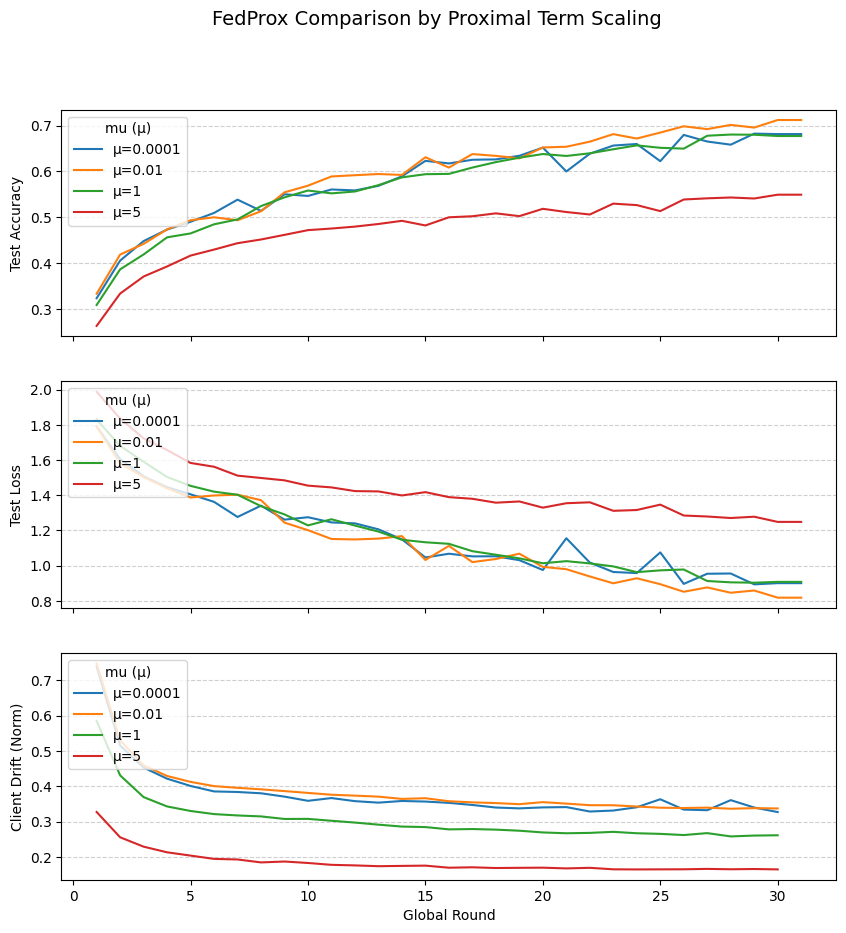

In [41]:
plot_metrics(metrics_exp_1, "FedProx Comparison by Proximal Term Scaling", label='μ', label_desc='mu')

In [28]:
#experimental setup 2.
from IPython.display import clear_output
metrics_exp_2 = {}
total_samples = len(trainset.dataset)
# for alpha in [1e-4, 0.01, 0.1, 1, 10]: 
#     f = fed_prox_exp(lr=1e-2, mu=0.01,num_clients=5,num_steps=75, global_runs=30, sampling_frac=1.0, alpha=alpha)
#     metrics_exp_1[alpha] = f.federated_method.round_metrics
#     clear_output(wait=True)

In [29]:
f = fed_prox_exp(lr=1e-2, mu=0.01,num_clients=5,num_steps=75, global_runs=30, sampling_frac=1.0, alpha=1e-4)
metrics_exp_2[1e-4] = f.federated_method.round_metrics
clear_output(wait=True)

/usr/local/lib/python3.11/dist-packages/fedlab/utils/dataset/functional.py:175: RuntimeWarning: invalid value encountered in cast
  proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
/usr/local/lib/python3.11/dist-packages/fedlab/utils/dataset/functional.py:174: RuntimeWarning: invalid value encountered in divide
  proportions = proportions / proportions.sum()
/usr/local/lib/python3.11/dist-packages/fedlab/utils/dataset/functional.py:172: RuntimeWarning: invalid value encountered in scalar multiply
  [p * (len(idx_j) < num_samples / num_clients) for p, idx_j in



--- Round 1/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.982747e-01
Client Drift Std: 1.221907e-01
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.018666e-01
Client Number: 2 Drift :3.328452e-01
Client Number: 0 Drift :3.510074e-01
Client Number: 3 Drift :3.668482e-01
Client Number: 1 Drift :6.388062e-01

Evaluate on round 1:


FedProx  | Test Loss: 2.2925, Test Acc: 23.14%

--- Round 2/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.956185e-01
Client Drift Std: 3.326662e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.756408e-01
Client Number: 0 Drift :3.780154e-01
Client Number: 2 Drift :3.782644e-01
Client Number: 3 Drift :3.842638e-01
Client Number: 1 Drift :4.619078e-01

Evaluate on round 2:


FedProx  | Test Loss: 2.3620, Test Acc: 26.13%

--- Round 3/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.900241e-01
Client Drift Std: 5.313276e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.844101e-01
Client Number: 2 Drift :3.883078e-01
Client Number: 3 Drift :3.885725e-01
Client Number: 4 Drift :3.886696e-01
Client Number: 1 Drift :4.001606e-01

Evaluate on round 3:


FedProx  | Test Loss: 2.4062, Test Acc: 29.13%

--- Round 4/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.840132e-01
Client Drift Std: 9.399510e-03
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :3.671396e-01
Client Number: 0 Drift :3.831844e-01
Client Number: 3 Drift :3.842938e-01
Client Number: 2 Drift :3.912222e-01
Client Number: 4 Drift :3.942260e-01

Evaluate on round 4:


FedProx  | Test Loss: 2.3815, Test Acc: 30.36%

--- Round 5/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.799688e-01
Client Drift Std: 1.254579e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :3.557007e-01
Client Number: 0 Drift :3.802385e-01
Client Number: 3 Drift :3.859818e-01
Client Number: 2 Drift :3.887694e-01
Client Number: 4 Drift :3.891536e-01

Evaluate on round 5:


FedProx  | Test Loss: 2.4143, Test Acc: 31.36%

--- Round 6/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.744730e-01
Client Drift Std: 1.796503e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :3.392592e-01
Client Number: 0 Drift :3.792608e-01
Client Number: 3 Drift :3.793126e-01
Client Number: 4 Drift :3.871589e-01
Client Number: 2 Drift :3.873737e-01

Evaluate on round 6:


FedProx  | Test Loss: 2.3650, Test Acc: 33.86%

--- Round 7/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.719914e-01
Client Drift Std: 1.797495e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :3.366243e-01
Client Number: 0 Drift :3.764739e-01
Client Number: 3 Drift :3.780950e-01
Client Number: 4 Drift :3.840175e-01
Client Number: 2 Drift :3.847464e-01

Evaluate on round 7:


FedProx  | Test Loss: 2.3800, Test Acc: 32.58%

--- Round 8/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.678462e-01
Client Drift Std: 2.077514e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :3.266359e-01
Client Number: 0 Drift :3.747419e-01
Client Number: 3 Drift :3.757455e-01
Client Number: 2 Drift :3.803836e-01
Client Number: 4 Drift :3.817244e-01

Evaluate on round 8:


FedProx  | Test Loss: 2.3548, Test Acc: 33.85%

--- Round 9/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.648428e-01
Client Drift Std: 2.620071e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :3.125391e-01
Client Number: 0 Drift :3.756292e-01
Client Number: 4 Drift :3.775187e-01
Client Number: 3 Drift :3.778885e-01
Client Number: 2 Drift :3.806383e-01

Evaluate on round 9:


FedProx  | Test Loss: 2.3154, Test Acc: 35.06%

--- Round 10/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.619300e-01
Client Drift Std: 2.686397e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :3.086345e-01
Client Number: 3 Drift :3.694288e-01
Client Number: 0 Drift :3.746769e-01
Client Number: 4 Drift :3.772132e-01
Client Number: 2 Drift :3.796967e-01

Evaluate on round 10:


FedProx  | Test Loss: 2.3519, Test Acc: 35.12%

--- Round 11/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.614405e-01
Client Drift Std: 2.954527e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :3.024873e-01
Client Number: 3 Drift :3.724537e-01
Client Number: 4 Drift :3.763983e-01
Client Number: 2 Drift :3.776167e-01
Client Number: 0 Drift :3.782464e-01

Evaluate on round 11:


FedProx  | Test Loss: 2.3086, Test Acc: 35.57%

--- Round 12/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.571713e-01
Client Drift Std: 3.130575e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.948039e-01
Client Number: 3 Drift :3.696021e-01
Client Number: 4 Drift :3.698176e-01
Client Number: 0 Drift :3.751782e-01
Client Number: 2 Drift :3.764547e-01

Evaluate on round 12:


FedProx  | Test Loss: 2.3155, Test Acc: 35.76%

--- Round 13/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.587758e-01
Client Drift Std: 3.003318e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.990374e-01
Client Number: 4 Drift :3.709516e-01
Client Number: 0 Drift :3.712973e-01
Client Number: 3 Drift :3.729562e-01
Client Number: 2 Drift :3.796363e-01

Evaluate on round 13:


FedProx  | Test Loss: 2.4582, Test Acc: 32.56%

--- Round 14/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.624822e-01
Client Drift Std: 3.389143e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.949207e-01
Client Number: 4 Drift :3.761753e-01
Client Number: 0 Drift :3.779079e-01
Client Number: 2 Drift :3.790386e-01
Client Number: 3 Drift :3.843687e-01

Evaluate on round 14:


FedProx  | Test Loss: 2.2929, Test Acc: 36.02%

--- Round 15/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.528457e-01
Client Drift Std: 3.279709e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.884791e-01
Client Number: 3 Drift :3.605886e-01
Client Number: 4 Drift :3.643755e-01
Client Number: 2 Drift :3.718166e-01
Client Number: 0 Drift :3.789684e-01

Evaluate on round 15:


FedProx  | Test Loss: 2.3240, Test Acc: 35.55%

--- Round 16/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.524277e-01
Client Drift Std: 3.488882e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.830765e-01
Client Number: 4 Drift :3.632471e-01
Client Number: 3 Drift :3.694872e-01
Client Number: 2 Drift :3.711032e-01
Client Number: 0 Drift :3.752246e-01

Evaluate on round 16:


FedProx  | Test Loss: 2.3057, Test Acc: 36.28%

--- Round 17/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.513505e-01
Client Drift Std: 2.906283e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.936779e-01
Client Number: 3 Drift :3.606362e-01
Client Number: 4 Drift :3.631459e-01
Client Number: 2 Drift :3.685791e-01
Client Number: 0 Drift :3.707137e-01

Evaluate on round 17:


FedProx  | Test Loss: 2.4447, Test Acc: 34.12%

--- Round 18/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.544161e-01
Client Drift Std: 3.655006e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.815422e-01
Client Number: 4 Drift :3.672811e-01
Client Number: 3 Drift :3.730231e-01
Client Number: 2 Drift :3.748643e-01
Client Number: 0 Drift :3.753699e-01

Evaluate on round 18:


FedProx  | Test Loss: 2.3034, Test Acc: 38.16%

--- Round 19/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.494798e-01
Client Drift Std: 3.422071e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.826394e-01
Client Number: 4 Drift :3.583221e-01
Client Number: 3 Drift :3.590870e-01
Client Number: 2 Drift :3.688617e-01
Client Number: 0 Drift :3.784885e-01

Evaluate on round 19:


FedProx  | Test Loss: 2.2582, Test Acc: 38.86%

--- Round 20/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.527641e-01
Client Drift Std: 3.283114e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.879057e-01
Client Number: 4 Drift :3.611545e-01
Client Number: 2 Drift :3.678250e-01
Client Number: 3 Drift :3.697056e-01
Client Number: 0 Drift :3.772297e-01

Evaluate on round 20:


FedProx  | Test Loss: 2.2997, Test Acc: 36.88%

--- Round 21/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.530355e-01
Client Drift Std: 3.773880e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.780201e-01
Client Number: 3 Drift :3.660138e-01
Client Number: 4 Drift :3.705994e-01
Client Number: 2 Drift :3.715352e-01
Client Number: 0 Drift :3.790087e-01

Evaluate on round 21:


FedProx  | Test Loss: 2.2946, Test Acc: 37.08%

--- Round 22/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.462752e-01
Client Drift Std: 3.629310e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.746151e-01
Client Number: 4 Drift :3.542191e-01
Client Number: 3 Drift :3.632367e-01
Client Number: 2 Drift :3.677841e-01
Client Number: 0 Drift :3.715209e-01

Evaluate on round 22:


FedProx  | Test Loss: 2.2206, Test Acc: 39.00%

--- Round 23/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.459438e-01
Client Drift Std: 3.597940e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.757115e-01
Client Number: 4 Drift :3.524430e-01
Client Number: 3 Drift :3.583367e-01
Client Number: 2 Drift :3.679899e-01
Client Number: 0 Drift :3.752381e-01

Evaluate on round 23:


FedProx  | Test Loss: 2.2225, Test Acc: 39.40%

--- Round 24/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.466228e-01
Client Drift Std: 3.671144e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.747311e-01
Client Number: 3 Drift :3.571190e-01
Client Number: 4 Drift :3.586410e-01
Client Number: 2 Drift :3.643630e-01
Client Number: 0 Drift :3.782600e-01

Evaluate on round 24:


FedProx  | Test Loss: 2.1630, Test Acc: 39.89%

--- Round 25/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.407176e-01
Client Drift Std: 3.581547e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.714464e-01
Client Number: 4 Drift :3.486210e-01
Client Number: 3 Drift :3.500679e-01
Client Number: 2 Drift :3.592282e-01
Client Number: 0 Drift :3.742245e-01

Evaluate on round 25:


FedProx  | Test Loss: 2.2376, Test Acc: 39.70%

--- Round 26/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.428306e-01
Client Drift Std: 3.616193e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.731983e-01
Client Number: 3 Drift :3.490348e-01
Client Number: 4 Drift :3.499952e-01
Client Number: 2 Drift :3.680343e-01
Client Number: 0 Drift :3.738905e-01

Evaluate on round 26:


FedProx  | Test Loss: 2.1961, Test Acc: 39.31%

--- Round 27/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.463199e-01
Client Drift Std: 3.417400e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.806717e-01
Client Number: 4 Drift :3.524663e-01
Client Number: 3 Drift :3.546556e-01
Client Number: 2 Drift :3.643734e-01
Client Number: 0 Drift :3.794324e-01

Evaluate on round 27:


FedProx  | Test Loss: 2.2282, Test Acc: 38.87%

--- Round 28/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.424925e-01
Client Drift Std: 3.615160e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.727397e-01
Client Number: 3 Drift :3.475612e-01
Client Number: 4 Drift :3.540413e-01
Client Number: 2 Drift :3.620422e-01
Client Number: 0 Drift :3.760779e-01

Evaluate on round 28:


FedProx  | Test Loss: 2.2274, Test Acc: 39.10%

--- Round 29/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.408103e-01
Client Drift Std: 3.682557e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.715063e-01
Client Number: 4 Drift :3.448544e-01
Client Number: 3 Drift :3.509950e-01
Client Number: 2 Drift :3.552937e-01
Client Number: 0 Drift :3.814023e-01

Evaluate on round 29:


FedProx  | Test Loss: 2.1872, Test Acc: 38.42%

--- Round 30/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.458374e-01
Client Drift Std: 3.872709e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.701717e-01
Client Number: 3 Drift :3.525883e-01
Client Number: 4 Drift :3.598602e-01
Client Number: 2 Drift :3.697579e-01
Client Number: 0 Drift :3.768088e-01

Evaluate on round 30:


FedProx  | Test Loss: 2.2309, Test Acc: 39.50%
Training Complete!


FedProx  | Test Loss: 2.2309, Test Acc: 39.50%


In [30]:
import json
with open('metrics_exp_2.json', 'w') as f:
    json.dump(metrics_exp_2, f, indent=4)

In [31]:
f = fed_prox_exp(lr=1e-2, mu=0.01,num_clients=5,num_steps=75, global_runs=30, sampling_frac=1.0, alpha=0.01)
metrics_exp_2[0.01] = f.federated_method.round_metrics
clear_output(wait=True)


--- Round 1/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.292480e-01
Client Drift Std: 1.064103e-01
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.344949e-01
Client Number: 3 Drift :5.001230e-01
Client Number: 4 Drift :5.790487e-01
Client Number: 1 Drift :6.061095e-01
Client Number: 2 Drift :6.264638e-01

Evaluate on round 1:


FedProx  | Test Loss: 2.2628, Test Acc: 14.02%

--- Round 2/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.855448e-01
Client Drift Std: 8.186523e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.368947e-01
Client Number: 3 Drift :4.584380e-01
Client Number: 4 Drift :5.283327e-01
Client Number: 2 Drift :5.501912e-01
Client Number: 1 Drift :5.538675e-01

Evaluate on round 2:


FedProx  | Test Loss: 2.2008, Test Acc: 16.89%

--- Round 3/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.549299e-01
Client Drift Std: 6.903856e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.315261e-01
Client Number: 3 Drift :4.266590e-01
Client Number: 4 Drift :4.996179e-01
Client Number: 2 Drift :5.019504e-01
Client Number: 1 Drift :5.148959e-01

Evaluate on round 3:


FedProx  | Test Loss: 2.1625, Test Acc: 19.25%

--- Round 4/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.380335e-01
Client Drift Std: 5.847615e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.363545e-01
Client Number: 3 Drift :4.093134e-01
Client Number: 4 Drift :4.737176e-01
Client Number: 2 Drift :4.760371e-01
Client Number: 1 Drift :4.947450e-01

Evaluate on round 4:


FedProx  | Test Loss: 2.1173, Test Acc: 22.69%

--- Round 5/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.240876e-01
Client Drift Std: 5.205519e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.337006e-01
Client Number: 3 Drift :3.983199e-01
Client Number: 2 Drift :4.535577e-01
Client Number: 4 Drift :4.607468e-01
Client Number: 1 Drift :4.741131e-01

Evaluate on round 5:


FedProx  | Test Loss: 2.0682, Test Acc: 24.97%

--- Round 6/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.127141e-01
Client Drift Std: 4.495229e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.362891e-01
Client Number: 3 Drift :3.876067e-01
Client Number: 4 Drift :4.373834e-01
Client Number: 2 Drift :4.452371e-01
Client Number: 1 Drift :4.570545e-01

Evaluate on round 6:


FedProx  | Test Loss: 2.0687, Test Acc: 24.41%

--- Round 7/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.038989e-01
Client Drift Std: 3.955126e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.366930e-01
Client Number: 3 Drift :3.815109e-01
Client Number: 4 Drift :4.286402e-01
Client Number: 2 Drift :4.296691e-01
Client Number: 1 Drift :4.429812e-01

Evaluate on round 7:


FedProx  | Test Loss: 2.0136, Test Acc: 27.51%

--- Round 8/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.942868e-01
Client Drift Std: 3.546514e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.339672e-01
Client Number: 3 Drift :3.740884e-01
Client Number: 4 Drift :4.141918e-01
Client Number: 2 Drift :4.224418e-01
Client Number: 1 Drift :4.267450e-01

Evaluate on round 8:


FedProx  | Test Loss: 1.9847, Test Acc: 28.05%

--- Round 9/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.877942e-01
Client Drift Std: 3.390635e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.344392e-01
Client Number: 3 Drift :3.625877e-01
Client Number: 4 Drift :4.024628e-01
Client Number: 2 Drift :4.175320e-01
Client Number: 1 Drift :4.219494e-01

Evaluate on round 9:


FedProx  | Test Loss: 2.0063, Test Acc: 28.55%

--- Round 10/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.808058e-01
Client Drift Std: 3.048655e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.289483e-01
Client Number: 3 Drift :3.658067e-01
Client Number: 4 Drift :3.909640e-01
Client Number: 2 Drift :4.058068e-01
Client Number: 1 Drift :4.125034e-01

Evaluate on round 10:


FedProx  | Test Loss: 1.9616, Test Acc: 31.55%

--- Round 11/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.771256e-01
Client Drift Std: 2.816664e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.327102e-01
Client Number: 3 Drift :3.550365e-01
Client Number: 4 Drift :3.947151e-01
Client Number: 2 Drift :4.011190e-01
Client Number: 1 Drift :4.020469e-01

Evaluate on round 11:


FedProx  | Test Loss: 1.9829, Test Acc: 29.99%

--- Round 12/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.716634e-01
Client Drift Std: 2.716163e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.278972e-01
Client Number: 3 Drift :3.520604e-01
Client Number: 4 Drift :3.870105e-01
Client Number: 2 Drift :3.952190e-01
Client Number: 1 Drift :3.961299e-01

Evaluate on round 12:


FedProx  | Test Loss: 1.8833, Test Acc: 33.26%

--- Round 13/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.709897e-01
Client Drift Std: 2.339395e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.345629e-01
Client Number: 3 Drift :3.531374e-01
Client Number: 4 Drift :3.818690e-01
Client Number: 2 Drift :3.887752e-01
Client Number: 1 Drift :3.966039e-01

Evaluate on round 13:


FedProx  | Test Loss: 1.8877, Test Acc: 33.54%

--- Round 14/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.671617e-01
Client Drift Std: 2.362986e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.307173e-01
Client Number: 3 Drift :3.477517e-01
Client Number: 4 Drift :3.802433e-01
Client Number: 2 Drift :3.878338e-01
Client Number: 1 Drift :3.892625e-01

Evaluate on round 14:


FedProx  | Test Loss: 1.8477, Test Acc: 35.64%

--- Round 15/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.651124e-01
Client Drift Std: 2.103826e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.322694e-01
Client Number: 3 Drift :3.479770e-01
Client Number: 4 Drift :3.794535e-01
Client Number: 1 Drift :3.827379e-01
Client Number: 2 Drift :3.831244e-01

Evaluate on round 15:


FedProx  | Test Loss: 1.8732, Test Acc: 34.57%

--- Round 16/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.590883e-01
Client Drift Std: 2.126325e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.248627e-01
Client Number: 3 Drift :3.443683e-01
Client Number: 4 Drift :3.692320e-01
Client Number: 2 Drift :3.755856e-01
Client Number: 1 Drift :3.813930e-01

Evaluate on round 16:


FedProx  | Test Loss: 1.8370, Test Acc: 35.35%

--- Round 17/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.592304e-01
Client Drift Std: 2.247010e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.260348e-01
Client Number: 3 Drift :3.392708e-01
Client Number: 4 Drift :3.702068e-01
Client Number: 2 Drift :3.776570e-01
Client Number: 1 Drift :3.829826e-01

Evaluate on round 17:


FedProx  | Test Loss: 1.8067, Test Acc: 36.64%

--- Round 18/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.552271e-01
Client Drift Std: 2.011649e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.225221e-01
Client Number: 3 Drift :3.423708e-01
Client Number: 4 Drift :3.635469e-01
Client Number: 2 Drift :3.702572e-01
Client Number: 1 Drift :3.774385e-01

Evaluate on round 18:


FedProx  | Test Loss: 1.8037, Test Acc: 36.59%

--- Round 19/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.542895e-01
Client Drift Std: 1.988315e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.231516e-01
Client Number: 3 Drift :3.395342e-01
Client Number: 4 Drift :3.653867e-01
Client Number: 2 Drift :3.661703e-01
Client Number: 1 Drift :3.772048e-01

Evaluate on round 19:


FedProx  | Test Loss: 1.7977, Test Acc: 36.52%

--- Round 20/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.510467e-01
Client Drift Std: 1.501233e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.265862e-01
Client Number: 3 Drift :3.421228e-01
Client Number: 4 Drift :3.566871e-01
Client Number: 2 Drift :3.609044e-01
Client Number: 1 Drift :3.689328e-01

Evaluate on round 20:


FedProx  | Test Loss: 1.7710, Test Acc: 37.13%

--- Round 21/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.508280e-01
Client Drift Std: 1.915168e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.180377e-01
Client Number: 3 Drift :3.410936e-01
Client Number: 2 Drift :3.586605e-01
Client Number: 4 Drift :3.675206e-01
Client Number: 1 Drift :3.688276e-01

Evaluate on round 21:


FedProx  | Test Loss: 1.8068, Test Acc: 35.94%

--- Round 22/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.469059e-01
Client Drift Std: 1.617576e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.212954e-01
Client Number: 3 Drift :3.353705e-01
Client Number: 4 Drift :3.537445e-01
Client Number: 2 Drift :3.594829e-01
Client Number: 1 Drift :3.646363e-01

Evaluate on round 22:


FedProx  | Test Loss: 1.7299, Test Acc: 38.66%

--- Round 23/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.471542e-01
Client Drift Std: 1.684735e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.214913e-01
Client Number: 3 Drift :3.351964e-01
Client Number: 2 Drift :3.508725e-01
Client Number: 4 Drift :3.602918e-01
Client Number: 1 Drift :3.679188e-01

Evaluate on round 23:


FedProx  | Test Loss: 1.7562, Test Acc: 38.33%

--- Round 24/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.423183e-01
Client Drift Std: 1.680352e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.205980e-01
Client Number: 3 Drift :3.261945e-01
Client Number: 2 Drift :3.484842e-01
Client Number: 4 Drift :3.497829e-01
Client Number: 1 Drift :3.665320e-01

Evaluate on round 24:


FedProx  | Test Loss: 1.7657, Test Acc: 37.72%

--- Round 25/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.410560e-01
Client Drift Std: 1.409256e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.200372e-01
Client Number: 3 Drift :3.322721e-01
Client Number: 2 Drift :3.436902e-01
Client Number: 4 Drift :3.476383e-01
Client Number: 1 Drift :3.616421e-01

Evaluate on round 25:


FedProx  | Test Loss: 1.6976, Test Acc: 40.40%

--- Round 26/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.389488e-01
Client Drift Std: 1.570642e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.137161e-01
Client Number: 3 Drift :3.329087e-01
Client Number: 4 Drift :3.424576e-01
Client Number: 2 Drift :3.438151e-01
Client Number: 1 Drift :3.618463e-01

Evaluate on round 26:


FedProx  | Test Loss: 1.6759, Test Acc: 40.72%

--- Round 27/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.390534e-01
Client Drift Std: 1.376433e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.225756e-01
Client Number: 3 Drift :3.254006e-01
Client Number: 2 Drift :3.387017e-01
Client Number: 4 Drift :3.507837e-01
Client Number: 1 Drift :3.578055e-01

Evaluate on round 27:


FedProx  | Test Loss: 1.6837, Test Acc: 41.31%

--- Round 28/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.392718e-01
Client Drift Std: 1.413498e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.180107e-01
Client Number: 3 Drift :3.314330e-01
Client Number: 2 Drift :3.379248e-01
Client Number: 4 Drift :3.513184e-01
Client Number: 1 Drift :3.576722e-01

Evaluate on round 28:


FedProx  | Test Loss: 1.6687, Test Acc: 41.25%

--- Round 29/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.386626e-01
Client Drift Std: 1.309687e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.188739e-01
Client Number: 3 Drift :3.354086e-01
Client Number: 2 Drift :3.362063e-01
Client Number: 4 Drift :3.435280e-01
Client Number: 1 Drift :3.592964e-01

Evaluate on round 29:


FedProx  | Test Loss: 1.6854, Test Acc: 40.20%

--- Round 30/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.346123e-01
Client Drift Std: 1.345969e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.135600e-01
Client Number: 3 Drift :3.295800e-01
Client Number: 2 Drift :3.326511e-01
Client Number: 4 Drift :3.441545e-01
Client Number: 1 Drift :3.531162e-01

Evaluate on round 30:


FedProx  | Test Loss: 1.6310, Test Acc: 42.01%
Training Complete!


FedProx  | Test Loss: 1.6310, Test Acc: 42.01%


In [32]:
import json
with open('metrics_exp_2.json', 'w') as f:
    json.dump(metrics_exp_2, f, indent=4)

In [33]:
f = fed_prox_exp(lr=1e-2, mu=0.01,num_clients=5,num_steps=75, global_runs=30, sampling_frac=1.0, alpha=0.1)
metrics_exp_2[0.1] = f.federated_method.round_metrics
clear_output(wait=True)


--- Round 1/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.879236e-01
Client Drift Std: 7.916899e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :5.739970e-01
Client Number: 1 Drift :6.479841e-01
Client Number: 0 Drift :6.928281e-01
Client Number: 4 Drift :7.092755e-01
Client Number: 2 Drift :8.155333e-01

Evaluate on round 1:


FedProx  | Test Loss: 2.1646, Test Acc: 14.88%

--- Round 2/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.089650e-01
Client Drift Std: 6.015806e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :5.492877e-01
Client Number: 1 Drift :5.777780e-01
Client Number: 0 Drift :5.838448e-01
Client Number: 4 Drift :6.112630e-01
Client Number: 2 Drift :7.226516e-01

Evaluate on round 2:


FedProx  | Test Loss: 1.9832, Test Acc: 24.80%

--- Round 3/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.598717e-01
Client Drift Std: 6.300488e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.219247e-01
Client Number: 3 Drift :5.296816e-01
Client Number: 4 Drift :5.301890e-01
Client Number: 1 Drift :5.318688e-01
Client Number: 2 Drift :6.856947e-01

Evaluate on round 3:


FedProx  | Test Loss: 1.8744, Test Acc: 27.79%

--- Round 4/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.127054e-01
Client Drift Std: 6.677727e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :4.590604e-01
Client Number: 0 Drift :4.788053e-01
Client Number: 4 Drift :4.790545e-01
Client Number: 1 Drift :5.033305e-01
Client Number: 2 Drift :6.432763e-01

Evaluate on round 4:


FedProx  | Test Loss: 1.7466, Test Acc: 32.69%

--- Round 5/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.008561e-01
Client Drift Std: 6.118405e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :4.503732e-01
Client Number: 4 Drift :4.595948e-01
Client Number: 3 Drift :4.684975e-01
Client Number: 1 Drift :5.094352e-01
Client Number: 2 Drift :6.163799e-01

Evaluate on round 5:


FedProx  | Test Loss: 1.6849, Test Acc: 35.86%

--- Round 6/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.861181e-01
Client Drift Std: 6.659252e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :4.402825e-01
Client Number: 4 Drift :4.407787e-01
Client Number: 3 Drift :4.502917e-01
Client Number: 1 Drift :4.837852e-01
Client Number: 2 Drift :6.154521e-01

Evaluate on round 6:


FedProx  | Test Loss: 1.6689, Test Acc: 34.92%

--- Round 7/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.709255e-01
Client Drift Std: 6.138078e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :4.297188e-01
Client Number: 3 Drift :4.329099e-01
Client Number: 0 Drift :4.355803e-01
Client Number: 1 Drift :4.654293e-01
Client Number: 2 Drift :5.909894e-01

Evaluate on round 7:


FedProx  | Test Loss: 1.5799, Test Acc: 40.78%

--- Round 8/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.608615e-01
Client Drift Std: 6.382181e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :4.137096e-01
Client Number: 0 Drift :4.282964e-01
Client Number: 3 Drift :4.285109e-01
Client Number: 1 Drift :4.470521e-01
Client Number: 2 Drift :5.867387e-01

Evaluate on round 8:


FedProx  | Test Loss: 1.5613, Test Acc: 39.83%

--- Round 9/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.591373e-01
Client Drift Std: 6.249360e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :4.082658e-01
Client Number: 0 Drift :4.171272e-01
Client Number: 1 Drift :4.399409e-01
Client Number: 3 Drift :4.498878e-01
Client Number: 2 Drift :5.804651e-01

Evaluate on round 9:


FedProx  | Test Loss: 1.5129, Test Acc: 42.87%

--- Round 10/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.506326e-01
Client Drift Std: 6.692425e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :4.046857e-01
Client Number: 3 Drift :4.086106e-01
Client Number: 0 Drift :4.194292e-01
Client Number: 1 Drift :4.379603e-01
Client Number: 2 Drift :5.824775e-01

Evaluate on round 10:


FedProx  | Test Loss: 1.4666, Test Acc: 44.66%

--- Round 11/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.604759e-01
Client Drift Std: 6.445066e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :4.058390e-01
Client Number: 0 Drift :4.103585e-01
Client Number: 1 Drift :4.271854e-01
Client Number: 3 Drift :4.813524e-01
Client Number: 2 Drift :5.776442e-01

Evaluate on round 11:


FedProx  | Test Loss: 1.5026, Test Acc: 43.79%

--- Round 12/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.439461e-01
Client Drift Std: 6.257698e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :4.038542e-01
Client Number: 4 Drift :4.044085e-01
Client Number: 3 Drift :4.186964e-01
Client Number: 1 Drift :4.247217e-01
Client Number: 2 Drift :5.680496e-01

Evaluate on round 12:


FedProx  | Test Loss: 1.4333, Test Acc: 45.92%

--- Round 13/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.485680e-01
Client Drift Std: 6.318951e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.875619e-01
Client Number: 0 Drift :3.970182e-01
Client Number: 3 Drift :4.390685e-01
Client Number: 1 Drift :4.546116e-01
Client Number: 2 Drift :5.645795e-01

Evaluate on round 13:


FedProx  | Test Loss: 1.4380, Test Acc: 45.51%

--- Round 14/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.462946e-01
Client Drift Std: 6.006802e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.917322e-01
Client Number: 0 Drift :4.007325e-01
Client Number: 1 Drift :4.362174e-01
Client Number: 3 Drift :4.430253e-01
Client Number: 2 Drift :5.597655e-01

Evaluate on round 14:


FedProx  | Test Loss: 1.4343, Test Acc: 46.37%

--- Round 15/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.406849e-01
Client Drift Std: 6.588764e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.845790e-01
Client Number: 0 Drift :3.884755e-01
Client Number: 1 Drift :4.139334e-01
Client Number: 3 Drift :4.534686e-01
Client Number: 2 Drift :5.629680e-01

Evaluate on round 15:


FedProx  | Test Loss: 1.4607, Test Acc: 44.71%

--- Round 16/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.344406e-01
Client Drift Std: 6.185710e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.874993e-01
Client Number: 4 Drift :3.898440e-01
Client Number: 3 Drift :4.111408e-01
Client Number: 1 Drift :4.293999e-01
Client Number: 2 Drift :5.543192e-01

Evaluate on round 16:


FedProx  | Test Loss: 1.3450, Test Acc: 50.27%

--- Round 17/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.253630e-01
Client Drift Std: 7.030467e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.773775e-01
Client Number: 3 Drift :3.825927e-01
Client Number: 0 Drift :3.882983e-01
Client Number: 1 Drift :4.149799e-01
Client Number: 2 Drift :5.635666e-01

Evaluate on round 17:


FedProx  | Test Loss: 1.3125, Test Acc: 51.77%

--- Round 18/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.177240e-01
Client Drift Std: 6.653836e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.748478e-01
Client Number: 4 Drift :3.787579e-01
Client Number: 0 Drift :3.797148e-01
Client Number: 1 Drift :4.063995e-01
Client Number: 2 Drift :5.488998e-01

Evaluate on round 18:


FedProx  | Test Loss: 1.3282, Test Acc: 50.97%

--- Round 19/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.282756e-01
Client Drift Std: 6.397898e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.744650e-01
Client Number: 4 Drift :3.785716e-01
Client Number: 3 Drift :4.104446e-01
Client Number: 1 Drift :4.280378e-01
Client Number: 2 Drift :5.498588e-01

Evaluate on round 19:


FedProx  | Test Loss: 1.2689, Test Acc: 53.45%

--- Round 20/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.157907e-01
Client Drift Std: 6.752661e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.674178e-01
Client Number: 0 Drift :3.811502e-01
Client Number: 3 Drift :3.823851e-01
Client Number: 1 Drift :3.986120e-01
Client Number: 2 Drift :5.493882e-01

Evaluate on round 20:


FedProx  | Test Loss: 1.3196, Test Acc: 51.66%

--- Round 21/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.172006e-01
Client Drift Std: 6.603451e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.677554e-01
Client Number: 4 Drift :3.728387e-01
Client Number: 3 Drift :3.752014e-01
Client Number: 1 Drift :4.285155e-01
Client Number: 2 Drift :5.416917e-01

Evaluate on round 21:


FedProx  | Test Loss: 1.2489, Test Acc: 53.83%

--- Round 22/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.170028e-01
Client Drift Std: 6.816204e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.681536e-01
Client Number: 0 Drift :3.709440e-01
Client Number: 3 Drift :3.759250e-01
Client Number: 1 Drift :4.225886e-01
Client Number: 2 Drift :5.474025e-01

Evaluate on round 22:


FedProx  | Test Loss: 1.2998, Test Acc: 52.08%

--- Round 23/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.219203e-01
Client Drift Std: 6.804613e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.607233e-01
Client Number: 0 Drift :3.624883e-01
Client Number: 3 Drift :4.074891e-01
Client Number: 1 Drift :4.322435e-01
Client Number: 2 Drift :5.466573e-01

Evaluate on round 23:


FedProx  | Test Loss: 1.3538, Test Acc: 50.34%

--- Round 24/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.110581e-01
Client Drift Std: 6.292753e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.537107e-01
Client Number: 4 Drift :3.755131e-01
Client Number: 1 Drift :3.937853e-01
Client Number: 3 Drift :3.995050e-01
Client Number: 2 Drift :5.327765e-01

Evaluate on round 24:


FedProx  | Test Loss: 1.2157, Test Acc: 55.70%

--- Round 25/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.144407e-01
Client Drift Std: 6.398731e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.648142e-01
Client Number: 0 Drift :3.649543e-01
Client Number: 3 Drift :3.892693e-01
Client Number: 1 Drift :4.165694e-01
Client Number: 2 Drift :5.365965e-01

Evaluate on round 25:


FedProx  | Test Loss: 1.2548, Test Acc: 53.93%

--- Round 26/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.032374e-01
Client Drift Std: 6.823057e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.573923e-01
Client Number: 4 Drift :3.640922e-01
Client Number: 3 Drift :3.663281e-01
Client Number: 1 Drift :3.905294e-01
Client Number: 2 Drift :5.378448e-01

Evaluate on round 26:


FedProx  | Test Loss: 1.3288, Test Acc: 51.37%

--- Round 27/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.079218e-01
Client Drift Std: 6.344729e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.520849e-01
Client Number: 4 Drift :3.581809e-01
Client Number: 3 Drift :3.906974e-01
Client Number: 1 Drift :4.114482e-01
Client Number: 2 Drift :5.271978e-01

Evaluate on round 27:


FedProx  | Test Loss: 1.1945, Test Acc: 56.93%

--- Round 28/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.981280e-01
Client Drift Std: 6.991153e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.511422e-01
Client Number: 4 Drift :3.518827e-01
Client Number: 0 Drift :3.598064e-01
Client Number: 1 Drift :3.932990e-01
Client Number: 2 Drift :5.345097e-01

Evaluate on round 28:


FedProx  | Test Loss: 1.1906, Test Acc: 57.04%

--- Round 29/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.999793e-01
Client Drift Std: 7.372897e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.428551e-01
Client Number: 0 Drift :3.458276e-01
Client Number: 4 Drift :3.583738e-01
Client Number: 1 Drift :4.149105e-01
Client Number: 2 Drift :5.379295e-01

Evaluate on round 29:


FedProx  | Test Loss: 1.2352, Test Acc: 55.45%

--- Round 30/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.033858e-01
Client Drift Std: 6.983671e-02
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :3.492318e-01
Client Number: 0 Drift :3.579262e-01
Client Number: 1 Drift :3.780285e-01
Client Number: 3 Drift :3.919295e-01
Client Number: 2 Drift :5.398129e-01

Evaluate on round 30:


FedProx  | Test Loss: 1.2336, Test Acc: 54.88%
Training Complete!


FedProx  | Test Loss: 1.2336, Test Acc: 54.88%


In [34]:
import json
with open('metrics_exp_2.json', 'w') as f:
    json.dump(metrics_exp_2, f, indent=4)

In [35]:
f = fed_prox_exp(lr=1e-2, mu=0.01,num_clients=5,num_steps=75, global_runs=30, sampling_frac=1.0, alpha=1)
metrics_exp_2[1] = f.federated_method.round_metrics
clear_output(wait=True)


--- Round 1/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 7.206137e-01
Client Drift Std: 2.825523e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :6.706244e-01
Client Number: 4 Drift :7.098355e-01
Client Number: 3 Drift :7.316293e-01
Client Number: 0 Drift :7.425132e-01
Client Number: 1 Drift :7.484663e-01

Evaluate on round 1:


FedProx  | Test Loss: 1.8925, Test Acc: 27.94%

--- Round 2/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.785237e-01
Client Drift Std: 2.454195e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :5.351419e-01
Client Number: 0 Drift :5.677447e-01
Client Number: 3 Drift :5.920873e-01
Client Number: 1 Drift :5.971880e-01
Client Number: 4 Drift :6.004564e-01

Evaluate on round 2:


FedProx  | Test Loss: 1.6601, Test Acc: 36.18%

--- Round 3/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.091502e-01
Client Drift Std: 1.794259e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :4.818375e-01
Client Number: 0 Drift :4.969003e-01
Client Number: 4 Drift :5.164613e-01
Client Number: 3 Drift :5.169060e-01
Client Number: 1 Drift :5.336458e-01

Evaluate on round 3:


FedProx  | Test Loss: 1.5149, Test Acc: 43.17%

--- Round 4/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.763474e-01
Client Drift Std: 2.456624e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :4.413803e-01
Client Number: 0 Drift :4.571224e-01
Client Number: 4 Drift :4.830203e-01
Client Number: 3 Drift :4.888900e-01
Client Number: 1 Drift :5.113240e-01

Evaluate on round 4:


FedProx  | Test Loss: 1.4558, Test Acc: 45.86%

--- Round 5/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.628424e-01
Client Drift Std: 1.864991e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :4.379571e-01
Client Number: 2 Drift :4.425057e-01
Client Number: 3 Drift :4.742239e-01
Client Number: 1 Drift :4.783288e-01
Client Number: 4 Drift :4.811963e-01

Evaluate on round 5:


FedProx  | Test Loss: 1.4383, Test Acc: 46.25%

--- Round 6/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.510104e-01
Client Drift Std: 2.110988e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :4.274476e-01
Client Number: 0 Drift :4.305497e-01
Client Number: 3 Drift :4.455478e-01
Client Number: 4 Drift :4.757031e-01
Client Number: 1 Drift :4.758039e-01

Evaluate on round 6:


FedProx  | Test Loss: 1.4873, Test Acc: 45.90%

--- Round 7/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.398511e-01
Client Drift Std: 1.853073e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :4.184076e-01
Client Number: 2 Drift :4.266061e-01
Client Number: 3 Drift :4.305059e-01
Client Number: 4 Drift :4.583428e-01
Client Number: 1 Drift :4.653934e-01

Evaluate on round 7:


FedProx  | Test Loss: 1.4077, Test Acc: 48.34%

--- Round 8/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.462806e-01
Client Drift Std: 3.433332e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :4.154981e-01
Client Number: 2 Drift :4.157089e-01
Client Number: 3 Drift :4.342863e-01
Client Number: 1 Drift :4.586870e-01
Client Number: 4 Drift :5.072225e-01

Evaluate on round 8:


FedProx  | Test Loss: 1.4075, Test Acc: 48.41%

--- Round 9/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.351111e-01
Client Drift Std: 1.953913e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :4.158336e-01
Client Number: 2 Drift :4.169358e-01
Client Number: 3 Drift :4.309865e-01
Client Number: 1 Drift :4.431408e-01
Client Number: 4 Drift :4.686586e-01

Evaluate on round 9:


FedProx  | Test Loss: 1.2755, Test Acc: 54.11%

--- Round 10/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.300347e-01
Client Drift Std: 1.872750e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :4.087065e-01
Client Number: 0 Drift :4.113323e-01
Client Number: 3 Drift :4.277052e-01
Client Number: 1 Drift :4.464023e-01
Client Number: 4 Drift :4.560270e-01

Evaluate on round 10:


FedProx  | Test Loss: 1.2666, Test Acc: 53.86%

--- Round 11/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.215441e-01
Client Drift Std: 1.761918e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.991162e-01
Client Number: 0 Drift :4.074872e-01
Client Number: 3 Drift :4.180498e-01
Client Number: 4 Drift :4.370501e-01
Client Number: 1 Drift :4.460170e-01

Evaluate on round 11:


FedProx  | Test Loss: 1.2376, Test Acc: 55.00%

--- Round 12/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.123785e-01
Client Drift Std: 1.261812e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.948596e-01
Client Number: 4 Drift :4.086773e-01
Client Number: 0 Drift :4.090521e-01
Client Number: 3 Drift :4.156202e-01
Client Number: 1 Drift :4.336834e-01

Evaluate on round 12:


FedProx  | Test Loss: 1.1770, Test Acc: 57.35%

--- Round 13/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.214330e-01
Client Drift Std: 2.927005e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.882344e-01
Client Number: 0 Drift :4.001227e-01
Client Number: 3 Drift :4.159915e-01
Client Number: 1 Drift :4.301862e-01
Client Number: 4 Drift :4.726304e-01

Evaluate on round 13:


FedProx  | Test Loss: 1.1540, Test Acc: 58.53%

--- Round 14/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.087498e-01
Client Drift Std: 1.323155e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.964030e-01
Client Number: 3 Drift :4.013861e-01
Client Number: 0 Drift :4.038578e-01
Client Number: 4 Drift :4.079717e-01
Client Number: 1 Drift :4.341302e-01

Evaluate on round 14:


FedProx  | Test Loss: 1.1657, Test Acc: 58.23%

--- Round 15/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.125015e-01
Client Drift Std: 2.559573e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.851877e-01
Client Number: 0 Drift :3.978756e-01
Client Number: 3 Drift :3.994952e-01
Client Number: 1 Drift :4.221272e-01
Client Number: 4 Drift :4.578218e-01

Evaluate on round 15:


FedProx  | Test Loss: 1.1839, Test Acc: 56.63%

--- Round 16/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.097955e-01
Client Drift Std: 2.981245e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.807999e-01
Client Number: 0 Drift :3.873197e-01
Client Number: 3 Drift :3.967893e-01
Client Number: 1 Drift :4.214168e-01
Client Number: 4 Drift :4.626518e-01

Evaluate on round 16:


FedProx  | Test Loss: 1.1603, Test Acc: 58.61%

--- Round 17/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.913092e-01
Client Drift Std: 2.077402e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.678122e-01
Client Number: 4 Drift :3.759962e-01
Client Number: 0 Drift :3.918038e-01
Client Number: 3 Drift :3.926214e-01
Client Number: 1 Drift :4.283124e-01

Evaluate on round 17:


FedProx  | Test Loss: 1.0808, Test Acc: 60.89%

--- Round 18/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.945868e-01
Client Drift Std: 1.874643e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.720372e-01
Client Number: 3 Drift :3.831275e-01
Client Number: 0 Drift :3.859748e-01
Client Number: 1 Drift :4.076839e-01
Client Number: 4 Drift :4.241104e-01

Evaluate on round 18:


FedProx  | Test Loss: 1.1136, Test Acc: 60.41%

--- Round 19/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.980166e-01
Client Drift Std: 2.448902e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.751134e-01
Client Number: 2 Drift :3.785823e-01
Client Number: 3 Drift :3.822947e-01
Client Number: 1 Drift :4.179998e-01
Client Number: 4 Drift :4.360929e-01

Evaluate on round 19:


FedProx  | Test Loss: 1.0429, Test Acc: 62.63%

--- Round 20/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.903377e-01
Client Drift Std: 1.562465e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.679667e-01
Client Number: 0 Drift :3.816034e-01
Client Number: 3 Drift :3.862823e-01
Client Number: 1 Drift :4.057592e-01
Client Number: 4 Drift :4.100767e-01

Evaluate on round 20:


FedProx  | Test Loss: 1.0432, Test Acc: 62.35%

--- Round 21/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.896804e-01
Client Drift Std: 2.351346e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.589555e-01
Client Number: 3 Drift :3.764938e-01
Client Number: 0 Drift :3.788177e-01
Client Number: 1 Drift :4.132987e-01
Client Number: 4 Drift :4.208362e-01

Evaluate on round 21:


FedProx  | Test Loss: 1.0415, Test Acc: 63.04%

--- Round 22/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.751153e-01
Client Drift Std: 9.821791e-03
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.630869e-01
Client Number: 3 Drift :3.696172e-01
Client Number: 4 Drift :3.749928e-01
Client Number: 0 Drift :3.752312e-01
Client Number: 1 Drift :3.926481e-01

Evaluate on round 22:


FedProx  | Test Loss: 1.0047, Test Acc: 64.29%

--- Round 23/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.844094e-01
Client Drift Std: 2.046663e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.647287e-01
Client Number: 3 Drift :3.682732e-01
Client Number: 0 Drift :3.703237e-01
Client Number: 1 Drift :4.081047e-01
Client Number: 4 Drift :4.106169e-01

Evaluate on round 23:


FedProx  | Test Loss: 0.9877, Test Acc: 64.86%

--- Round 24/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.729027e-01
Client Drift Std: 1.058630e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.603735e-01
Client Number: 4 Drift :3.656956e-01
Client Number: 0 Drift :3.701502e-01
Client Number: 3 Drift :3.774025e-01
Client Number: 1 Drift :3.908916e-01

Evaluate on round 24:


FedProx  | Test Loss: 0.9667, Test Acc: 65.64%

--- Round 25/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.756396e-01
Client Drift Std: 1.675653e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.491268e-01
Client Number: 0 Drift :3.658641e-01
Client Number: 3 Drift :3.772148e-01
Client Number: 4 Drift :3.925297e-01
Client Number: 1 Drift :3.934627e-01

Evaluate on round 25:


FedProx  | Test Loss: 0.9559, Test Acc: 65.55%

--- Round 26/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.690520e-01
Client Drift Std: 1.285205e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.499838e-01
Client Number: 3 Drift :3.632601e-01
Client Number: 0 Drift :3.656790e-01
Client Number: 1 Drift :3.801026e-01
Client Number: 4 Drift :3.862345e-01

Evaluate on round 26:


FedProx  | Test Loss: 0.9314, Test Acc: 67.38%

--- Round 27/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.784360e-01
Client Drift Std: 2.655383e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.489734e-01
Client Number: 3 Drift :3.625630e-01
Client Number: 0 Drift :3.640546e-01
Client Number: 1 Drift :3.938784e-01
Client Number: 4 Drift :4.227106e-01

Evaluate on round 27:


FedProx  | Test Loss: 0.9364, Test Acc: 66.75%

--- Round 28/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.756926e-01
Client Drift Std: 1.719170e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.514773e-01
Client Number: 0 Drift :3.610117e-01
Client Number: 3 Drift :3.801674e-01
Client Number: 4 Drift :3.872717e-01
Client Number: 1 Drift :3.985348e-01

Evaluate on round 28:


FedProx  | Test Loss: 0.9300, Test Acc: 66.76%

--- Round 29/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.755238e-01
Client Drift Std: 2.166916e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.544530e-01
Client Number: 3 Drift :3.595438e-01
Client Number: 0 Drift :3.650700e-01
Client Number: 1 Drift :3.849442e-01
Client Number: 4 Drift :4.136079e-01

Evaluate on round 29:


FedProx  | Test Loss: 0.9449, Test Acc: 66.45%

--- Round 30/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.712042e-01
Client Drift Std: 1.397404e-02
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :3.525072e-01
Client Number: 0 Drift :3.646289e-01
Client Number: 3 Drift :3.684297e-01
Client Number: 1 Drift :3.756738e-01
Client Number: 4 Drift :3.947813e-01

Evaluate on round 30:


FedProx  | Test Loss: 0.9566, Test Acc: 65.88%
Training Complete!


FedProx  | Test Loss: 0.9566, Test Acc: 65.88%


In [36]:
import json
with open('metrics_exp_2.json', 'w') as f:
    json.dump(metrics_exp_2, f, indent=4)

In [37]:
f = fed_prox_exp(lr=1e-2, mu=0.01,num_clients=5,num_steps=75, global_runs=30, sampling_frac=1.0, alpha=10)
metrics_exp_2[10] = f.federated_method.round_metrics
clear_output(wait=True)


--- Round 1/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 7.516315e-01
Client Drift Std: 4.019643e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :7.006628e-01
Client Number: 3 Drift :7.277157e-01
Client Number: 4 Drift :7.316287e-01
Client Number: 1 Drift :7.971933e-01
Client Number: 2 Drift :8.009570e-01

Evaluate on round 1:


FedProx  | Test Loss: 1.7831, Test Acc: 33.82%

--- Round 2/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.307263e-01
Client Drift Std: 4.309677e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :4.784867e-01
Client Number: 3 Drift :5.034758e-01
Client Number: 4 Drift :5.084990e-01
Client Number: 1 Drift :5.729873e-01
Client Number: 2 Drift :5.901827e-01

Evaluate on round 2:


FedProx  | Test Loss: 1.5521, Test Acc: 42.45%

--- Round 3/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.576751e-01
Client Drift Std: 4.008230e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :4.070593e-01
Client Number: 3 Drift :4.343734e-01
Client Number: 4 Drift :4.379757e-01
Client Number: 1 Drift :4.955983e-01
Client Number: 2 Drift :5.133688e-01

Evaluate on round 3:


FedProx  | Test Loss: 1.4596, Test Acc: 45.69%

--- Round 4/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.229166e-01
Client Drift Std: 3.692622e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.762459e-01
Client Number: 4 Drift :3.971244e-01
Client Number: 3 Drift :4.097372e-01
Client Number: 1 Drift :4.575723e-01
Client Number: 2 Drift :4.739031e-01

Evaluate on round 4:


FedProx  | Test Loss: 1.4218, Test Acc: 47.30%

--- Round 5/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.055000e-01
Client Drift Std: 3.644917e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.636152e-01
Client Number: 3 Drift :3.794976e-01
Client Number: 4 Drift :3.880036e-01
Client Number: 1 Drift :4.367692e-01
Client Number: 2 Drift :4.596144e-01

Evaluate on round 5:


FedProx  | Test Loss: 1.3614, Test Acc: 49.24%

--- Round 6/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.953909e-01
Client Drift Std: 3.607327e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.512460e-01
Client Number: 3 Drift :3.707774e-01
Client Number: 4 Drift :3.820477e-01
Client Number: 1 Drift :4.222390e-01
Client Number: 2 Drift :4.506444e-01

Evaluate on round 6:


FedProx  | Test Loss: 1.2994, Test Acc: 52.41%

--- Round 7/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.885997e-01
Client Drift Std: 3.472276e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.450048e-01
Client Number: 3 Drift :3.703054e-01
Client Number: 4 Drift :3.716572e-01
Client Number: 1 Drift :4.138938e-01
Client Number: 2 Drift :4.421376e-01

Evaluate on round 7:


FedProx  | Test Loss: 1.2439, Test Acc: 54.56%

--- Round 8/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.868299e-01
Client Drift Std: 3.618839e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.461958e-01
Client Number: 3 Drift :3.614188e-01
Client Number: 4 Drift :3.697653e-01
Client Number: 1 Drift :4.124737e-01
Client Number: 2 Drift :4.442959e-01

Evaluate on round 8:


FedProx  | Test Loss: 1.2696, Test Acc: 53.44%

--- Round 9/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.810187e-01
Client Drift Std: 3.115321e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.392432e-01
Client Number: 3 Drift :3.609056e-01
Client Number: 4 Drift :3.728338e-01
Client Number: 1 Drift :4.065494e-01
Client Number: 2 Drift :4.255617e-01

Evaluate on round 9:


FedProx  | Test Loss: 1.1943, Test Acc: 55.91%

--- Round 10/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.783050e-01
Client Drift Std: 3.254466e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.365892e-01
Client Number: 3 Drift :3.557200e-01
Client Number: 4 Drift :3.680934e-01
Client Number: 1 Drift :4.064742e-01
Client Number: 2 Drift :4.246484e-01

Evaluate on round 10:


FedProx  | Test Loss: 1.1649, Test Acc: 57.79%

--- Round 11/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.738206e-01
Client Drift Std: 2.826169e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.300739e-01
Client Number: 3 Drift :3.630242e-01
Client Number: 4 Drift :3.669541e-01
Client Number: 1 Drift :4.006171e-01
Client Number: 2 Drift :4.084339e-01

Evaluate on round 11:


FedProx  | Test Loss: 1.1470, Test Acc: 57.95%

--- Round 12/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.684774e-01
Client Drift Std: 2.888975e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.280202e-01
Client Number: 3 Drift :3.525121e-01
Client Number: 4 Drift :3.601650e-01
Client Number: 1 Drift :3.931956e-01
Client Number: 2 Drift :4.084939e-01

Evaluate on round 12:


FedProx  | Test Loss: 1.1159, Test Acc: 59.56%

--- Round 13/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.622598e-01
Client Drift Std: 3.026430e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.194803e-01
Client Number: 4 Drift :3.493493e-01
Client Number: 3 Drift :3.495722e-01
Client Number: 1 Drift :3.899623e-01
Client Number: 2 Drift :4.029350e-01

Evaluate on round 13:


FedProx  | Test Loss: 1.0459, Test Acc: 62.38%

--- Round 14/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.590224e-01
Client Drift Std: 2.783533e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.194331e-01
Client Number: 4 Drift :3.472556e-01
Client Number: 3 Drift :3.481922e-01
Client Number: 1 Drift :3.824537e-01
Client Number: 2 Drift :3.977773e-01

Evaluate on round 14:


FedProx  | Test Loss: 1.0630, Test Acc: 61.88%

--- Round 15/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.534757e-01
Client Drift Std: 2.947518e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.159159e-01
Client Number: 4 Drift :3.384331e-01
Client Number: 3 Drift :3.384617e-01
Client Number: 1 Drift :3.773974e-01
Client Number: 2 Drift :3.971706e-01

Evaluate on round 15:


FedProx  | Test Loss: 1.0243, Test Acc: 62.73%

--- Round 16/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.560377e-01
Client Drift Std: 3.427771e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.051899e-01
Client Number: 4 Drift :3.437777e-01
Client Number: 3 Drift :3.457080e-01
Client Number: 1 Drift :3.797989e-01
Client Number: 2 Drift :4.057137e-01

Evaluate on round 16:


FedProx  | Test Loss: 1.0174, Test Acc: 63.51%

--- Round 17/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.499740e-01
Client Drift Std: 3.066487e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.072779e-01
Client Number: 3 Drift :3.311256e-01
Client Number: 4 Drift :3.447965e-01
Client Number: 1 Drift :3.717006e-01
Client Number: 2 Drift :3.949696e-01

Evaluate on round 17:


FedProx  | Test Loss: 0.9896, Test Acc: 64.87%

--- Round 18/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.457112e-01
Client Drift Std: 2.814006e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.101676e-01
Client Number: 3 Drift :3.305747e-01
Client Number: 4 Drift :3.328333e-01
Client Number: 1 Drift :3.656328e-01
Client Number: 2 Drift :3.893477e-01

Evaluate on round 18:


FedProx  | Test Loss: 0.9523, Test Acc: 65.88%

--- Round 19/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.459666e-01
Client Drift Std: 2.856102e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.029271e-01
Client Number: 4 Drift :3.333134e-01
Client Number: 3 Drift :3.403633e-01
Client Number: 1 Drift :3.677788e-01
Client Number: 2 Drift :3.854506e-01

Evaluate on round 19:


FedProx  | Test Loss: 0.9923, Test Acc: 64.71%

--- Round 20/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.420109e-01
Client Drift Std: 3.116109e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.009306e-01
Client Number: 4 Drift :3.244652e-01
Client Number: 3 Drift :3.310431e-01
Client Number: 1 Drift :3.642048e-01
Client Number: 2 Drift :3.894109e-01

Evaluate on round 20:


FedProx  | Test Loss: 0.9665, Test Acc: 65.89%

--- Round 21/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.414861e-01
Client Drift Std: 2.945953e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :3.043334e-01
Client Number: 3 Drift :3.241439e-01
Client Number: 4 Drift :3.278517e-01
Client Number: 1 Drift :3.668462e-01
Client Number: 2 Drift :3.842553e-01

Evaluate on round 21:


FedProx  | Test Loss: 0.9687, Test Acc: 65.54%

--- Round 22/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.356519e-01
Client Drift Std: 2.599702e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.974964e-01
Client Number: 3 Drift :3.219581e-01
Client Number: 4 Drift :3.293527e-01
Client Number: 1 Drift :3.630576e-01
Client Number: 2 Drift :3.663946e-01

Evaluate on round 22:


FedProx  | Test Loss: 0.9042, Test Acc: 67.85%

--- Round 23/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.348059e-01
Client Drift Std: 2.597396e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.961622e-01
Client Number: 3 Drift :3.237270e-01
Client Number: 4 Drift :3.264448e-01
Client Number: 1 Drift :3.634094e-01
Client Number: 2 Drift :3.642863e-01

Evaluate on round 23:


FedProx  | Test Loss: 0.9033, Test Acc: 68.20%

--- Round 24/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.329370e-01
Client Drift Std: 2.989293e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.986481e-01
Client Number: 3 Drift :3.131169e-01
Client Number: 4 Drift :3.166070e-01
Client Number: 1 Drift :3.594421e-01
Client Number: 2 Drift :3.768708e-01

Evaluate on round 24:


FedProx  | Test Loss: 0.9147, Test Acc: 67.58%

--- Round 25/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.317711e-01
Client Drift Std: 2.515438e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.974823e-01
Client Number: 3 Drift :3.170663e-01
Client Number: 4 Drift :3.235169e-01
Client Number: 1 Drift :3.546952e-01
Client Number: 2 Drift :3.660948e-01

Evaluate on round 25:


FedProx  | Test Loss: 0.8774, Test Acc: 68.82%

--- Round 26/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.315953e-01
Client Drift Std: 2.544202e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.956693e-01
Client Number: 3 Drift :3.195367e-01
Client Number: 4 Drift :3.220493e-01
Client Number: 1 Drift :3.551464e-01
Client Number: 2 Drift :3.655749e-01

Evaluate on round 26:


FedProx  | Test Loss: 0.8791, Test Acc: 68.95%

--- Round 27/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.319744e-01
Client Drift Std: 3.165962e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.934805e-01
Client Number: 3 Drift :3.109579e-01
Client Number: 4 Drift :3.199832e-01
Client Number: 1 Drift :3.537939e-01
Client Number: 2 Drift :3.816565e-01

Evaluate on round 27:


FedProx  | Test Loss: 0.8344, Test Acc: 70.20%

--- Round 28/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.284916e-01
Client Drift Std: 2.892646e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.887104e-01
Client Number: 3 Drift :3.122872e-01
Client Number: 4 Drift :3.201373e-01
Client Number: 1 Drift :3.506879e-01
Client Number: 2 Drift :3.706354e-01

Evaluate on round 28:


FedProx  | Test Loss: 0.8546, Test Acc: 70.07%

--- Round 29/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.314679e-01
Client Drift Std: 2.984045e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.897300e-01
Client Number: 3 Drift :3.154433e-01
Client Number: 4 Drift :3.224182e-01
Client Number: 1 Drift :3.565197e-01
Client Number: 2 Drift :3.732282e-01

Evaluate on round 29:


FedProx  | Test Loss: 0.8150, Test Acc: 71.07%

--- Round 30/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.270200e-01
Client Drift Std: 2.740049e-02
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :2.923381e-01
Client Number: 3 Drift :3.115157e-01
Client Number: 4 Drift :3.149142e-01
Client Number: 1 Drift :3.475824e-01
Client Number: 2 Drift :3.687496e-01

Evaluate on round 30:


FedProx  | Test Loss: 0.8143, Test Acc: 71.19%
Training Complete!


FedProx  | Test Loss: 0.8143, Test Acc: 71.19%


In [38]:
import json
with open('metrics_exp_2.json', 'w') as f:
    json.dump(metrics_exp_2, f, indent=4)

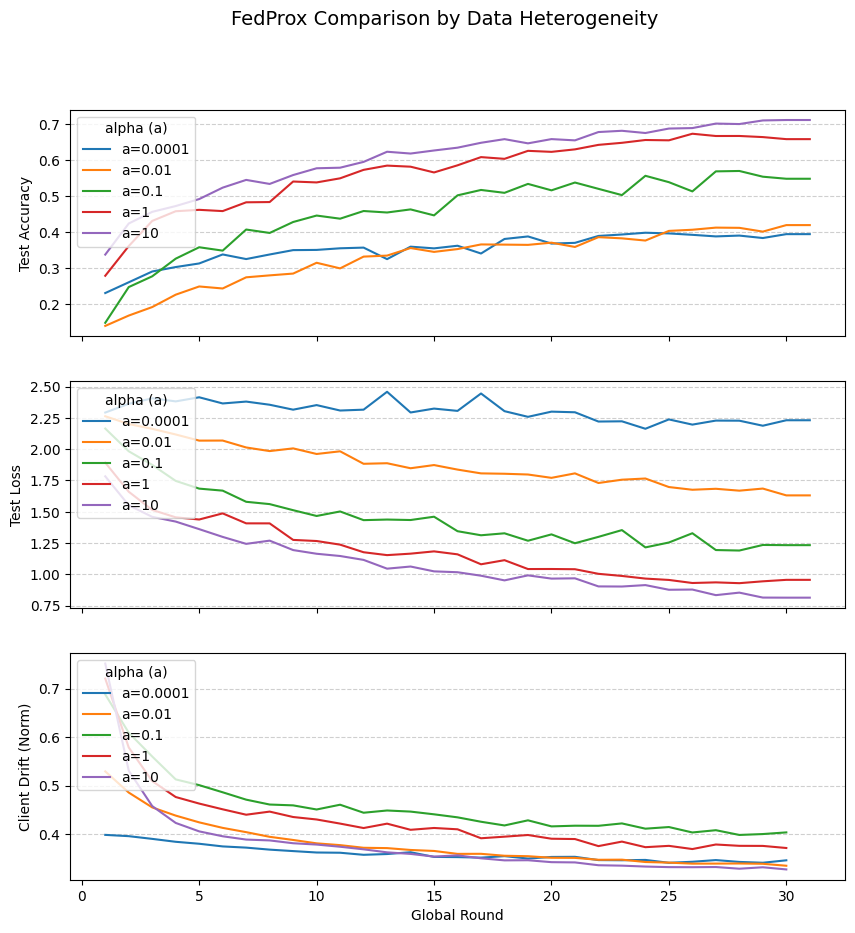

In [42]:
plot_metrics(metrics_exp_2, "FedProx Comparison by Data Heterogeneity", label="a", label_desc="alpha")